##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Playing CartPole with the Actor-Critic method


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/reinforcement_learning/actor_critic.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/reinforcement_learning/actor_critic.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/reinforcement_learning/actor_critic.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to implement the [Actor-Critic](https://papers.nips.cc/paper/1786-actor-critic-algorithms.pdf) method using TensorFlow to train an agent on the [Open AI Gym](https://gym.openai.com/) [`CartPole-v0`](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) environment.
The reader is assumed to have some familiarity with [policy gradient methods](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf) of [(deep) reinforcement learning](https://en.wikipedia.org/wiki/Deep_reinforcement_learning). 


**Actor-Critic methods**

Actor-Critic methods are [temporal difference (TD) learning](https://en.wikipedia.org/wiki/Temporal_difference_learning) methods that represent the policy function independent of the value function.

A policy function (or policy) returns a probability distribution over actions that the agent can take based on the given state.
A value function determines the expected return for an agent starting at a given state and acting according to a particular policy forever after.

In the Actor-Critic method, the policy is referred to as the *actor* that proposes a set of possible actions given a state, and the estimated value function is referred to as the *critic*, which evaluates actions taken by the *actor* based on the given policy.

In this tutorial, both the *Actor* and *Critic* will be represented using one neural network with two outputs.


**`CartPole-v0`**

In the [`CartPole-v0` environment](https://www.gymlibrary.dev/environments/classic_control/cart_pole/), a pole is attached to a cart moving along a frictionless track.
The pole starts upright and the goal of the agent is to prevent it from falling over by applying a force of `-1` or `+1` to the cart.
A reward of `+1` is given for every time step the pole remains upright.
An episode ends when: 1) the pole is more than 15 degrees from vertical; or 2) the cart moves more than 2.4 units from the center.

<center>
  <figure>
    <image src="https://tensorflow.org/tutorials/reinforcement_learning/images/cartpole-v0.gif">
    <figcaption>
      Trained actor-critic model in Cartpole-v0 environment
    </figcaption>
  </figure>
</center>


The problem is considered "solved" when the average total reward for the episode reaches 195 over 100 consecutive trials.

## Setup

Import necessary packages and configure global settings.


In [2]:
!pip install gym[classic_control]
!pip install pyglet

  Installing build dependencies ... -

 \

 |

 done


  Getting requirements to build wheel ... -

 done


  Preparing metadata (pyproject.toml) ... -

 done


 \

 |

 done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827633 sha256=6ee1b00b0ab97f1d7d8f076e998d538be738ecece62e9559c3cadcd0f3a2d048
  Stored in directory: /home/kbuilder/.cache/pip/wheels/fc/bf/16/63ad354aa94e522b5fddf1729d8dfc47ad5980079054d4f714
Successfully built gym


In [3]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y python-opengl > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [4]:
import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple


# Create the environment
env = gym.make("CartPole-v1")

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

2022-11-29 02:27:14.647672: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-29 02:27:14.647860: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-29 02:27:14.647875: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## The model

The *Actor* and *Critic* will be modeled using one neural network that generates the action probabilities and Critic value respectively. This tutorial uses model subclassing to define the model. 

During the forward pass, the model will take in the state as the input and will output both action probabilities and critic value $V$, which models the state-dependent [value function](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#value-functions). The goal is to train a model that chooses actions based on a policy $\pi$ that maximizes expected [return](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#reward-and-return).

For `CartPole-v0`, there are four values representing the state: cart position, cart-velocity, pole angle and pole velocity respectively. The agent can take two actions to push the cart left (`0`) and right (`1`), respectively.

Refer to [Gym's Cart Pole documentation page](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) and [_Neuronlike adaptive elements that can solve difficult learning control problems_](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf) by Barto, Sutton and Anderson (1983) for more information.


In [5]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self, 
      num_actions: int, 
      num_hidden_units: int):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [6]:
num_actions = env.action_space.n  # 2
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

## Train the agent

To train the agent, you will follow these steps:

1. Run the agent on the environment to collect training data per episode.
2. Compute expected return at each time step.
3. Compute the loss for the combined Actor-Critic model.
4. Compute gradients and update network parameters.
5. Repeat 1-4 until either success criterion or max episodes has been reached.


### 1. Collect training data

As in supervised learning, in order to train the actor-critic model, you need
to have training data. However, in order to collect such data, the model would
need to be "run" in the environment.

Training data is collected for each episode. Then at each time step, the model's forward pass will be run on the environment's state in order to generate action probabilities and the critic value based on the current policy parameterized by the model's weights.

The next action will be sampled from the action probabilities generated by the model, which would then be applied to the environment, causing the next state and reward to be generated.

This process is implemented in the `run_episode` function, which uses TensorFlow operations so that it can later be compiled into a TensorFlow graph for faster training. Note that `tf.TensorArray`s were used to support Tensor iteration on variable length arrays.

In [7]:
# Wrap Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """Returns state, reward and done flag given an action."""

  state, reward, done, truncated, info = env.step(action)
  return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
  return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])

In [8]:
def run_episode(
    initial_state: tf.Tensor,  
    model: tf.keras.Model, 
    max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
  """Runs a single episode to collect training data."""

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    # Convert state into a batched tensor (batch size = 1)
    state = tf.expand_dims(state, 0)
  
    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)
  
    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])
  
    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)
  
    # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()
  
  return action_probs, values, rewards

### 2. Compute the expected returns

The sequence of rewards for each timestep $t$, $\{r_{t}\}^{T}_{t=1}$ collected during one episode is converted into a sequence of expected returns $\{G_{t}\}^{T}_{t=1}$ in which the sum of rewards is taken from the current timestep $t$ to $T$ and each reward is multiplied with an exponentially decaying discount factor $\gamma$:

$$G_{t} = \sum^{T}_{t'=t} \gamma^{t'-t}r_{t'}$$

Since $\gamma\in(0,1)$, rewards further out from the current timestep are given less weight.

Intuitively, expected return simply implies that rewards now are better than rewards later. In a mathematical sense, it is to ensure that the sum of the rewards converges.

To stabilize training, the resulting sequence of returns is also standardized (i.e. to have zero mean and unit standard deviation).


In [9]:
def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))

  return returns

### 3. The Actor-Critic loss

Since you're using a hybrid Actor-Critic model, the chosen loss function is a combination of Actor and Critic losses for training, as shown below:

$$L = L_{actor} + L_{critic}$$

#### The Actor loss

The Actor loss is based on [policy gradients with the Critic as a state dependent baseline](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s) and computed with single-sample (per-episode) estimates.

$$L_{actor} = -\sum^{T}_{t=1} \log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$$

where:
- $T$: the number of timesteps per episode, which can vary per episode
- $s_{t}$: the state at timestep $t$
- $a_{t}$: chosen action at timestep $t$ given state $s$
- $\pi_{\theta}$: is the policy (Actor) parameterized by $\theta$
- $V^{\pi}_{\theta}$: is the value function (Critic) also parameterized by $\theta$
- $G = G_{t}$: the expected return for a given state, action pair at timestep $t$

A negative term is added to the sum since the idea is to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.

<br>

##### The Advantage

The $G - V$ term in our $L_{actor}$ formulation is called the [Advantage](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions), which indicates how much better an action is given a particular state over a random action selected according to the policy $\pi$ for that state.

While it's possible to exclude a baseline, this may result in high variance during training. And the nice thing about choosing the critic $V$ as a baseline is that it trained to be as close as possible to $G$, leading to a lower variance.

In addition, without the Critic, the algorithm would try to increase probabilities for actions taken on a particular state based on expected return, which may not make much of a difference if the relative probabilities between actions remain the same.

For instance, suppose that two actions for a given state would yield the same expected return. Without the Critic, the algorithm would try to raise the probability of these actions based on the objective $J$. With the Critic, it may turn out that there's no Advantage ($G - V = 0$), and thus no benefit gained in increasing the actions' probabilities and the algorithm would set the gradients to zero.

<br>

#### The Critic loss

Training $V$ to be as close possible to $G$ can be set up as a regression problem with the following loss function:

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

where $L_{\delta}$ is the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is less sensitive to outliers in data than squared-error loss.


In [10]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined Actor-Critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

### 4. Define the training step to update parameters

All of the steps above are combined into a training step that is run every episode. All steps leading up to the loss function are executed with the `tf.GradientTape` context to enable automatic differentiation.

This tutorial uses the Adam optimizer to apply the gradients to the model parameters.

The sum of the undiscounted rewards, `episode_reward`, is also computed in this step. This value will be used later on to evaluate if the success criterion is met.

The `tf.function` context is applied to the `train_step` function so that it can be compiled into a callable TensorFlow graph, which can lead to 10x speedup in training.


In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int) -> tf.Tensor:
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(
        initial_state, model, max_steps_per_episode) 

    # Calculate the expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

    # Calculate the loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

### 5. Run the training loop

Training is executed by running the training step until either the success criterion or maximum number of episodes is reached.  

A running record of episode rewards is kept in a queue. Once 100 trials are reached, the oldest reward is removed at the left (tail) end of the queue and the newest one is added at the head (right). A running sum of the rewards is also maintained for computational efficiency.

Depending on your runtime, training can finish in less than a minute.

In [12]:
%%time

min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 500

# `CartPole-v1` is considered solved if average reward is >= 475 over 500 
# consecutive trials
reward_threshold = 475
running_reward = 0

# The discount factor for future rewards
gamma = 0.99

# Keep the last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

t = tqdm.trange(max_episodes)
for i in t:
    initial_state, info = env.reset()
    initial_state = tf.constant(initial_state, dtype=tf.float32)
    episode_reward = int(train_step(
        initial_state, model, optimizer, gamma, max_steps_per_episode))
    
    episodes_reward.append(episode_reward)
    running_reward = statistics.mean(episodes_reward)
  

    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)
  
    # Show the average episode reward every 10 episodes
    if i % 10 == 0:
      pass # print(f'Episode {i}: average reward: {avg_reward}')
  
    if running_reward > reward_threshold and i >= min_episodes_criterion:  
        break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



  0%|          | 0/10000 [00:05<?, ?it/s, episode_reward=14, running_reward=14]


  0%|          | 1/10000 [00:05<15:11:39,  5.47s/it, episode_reward=14, running_reward=14]


  0%|          | 1/10000 [00:05<15:11:39,  5.47s/it, episode_reward=19, running_reward=16.5]


  0%|          | 1/10000 [00:05<15:11:39,  5.47s/it, episode_reward=18, running_reward=17]  


  0%|          | 1/10000 [00:05<15:11:39,  5.47s/it, episode_reward=23, running_reward=18.5]


  0%|          | 4/10000 [00:05<2:57:09,  1.06s/it, episode_reward=23, running_reward=18.5] 


  0%|          | 4/10000 [00:05<2:57:09,  1.06s/it, episode_reward=42, running_reward=23.2]


  0%|          | 4/10000 [00:05<2:57:09,  1.06s/it, episode_reward=44, running_reward=26.7]


  0%|          | 6/10000 [00:05<1:45:40,  1.58it/s, episode_reward=44, running_reward=26.7]


  0%|          | 6/10000 [00:05<1:45:40,  1.58it/s, episode_reward=11, running_reward=24.4]


  0%|          | 6/10000 [00:05<1:45:40,  1.58it/s, episode_reward=57, running_reward=28.5]


  0%|          | 8/10000 [00:05<1:09:15,  2.40it/s, episode_reward=57, running_reward=28.5]


  0%|          | 8/10000 [00:05<1:09:15,  2.40it/s, episode_reward=31, running_reward=28.8]


  0%|          | 8/10000 [00:05<1:09:15,  2.40it/s, episode_reward=12, running_reward=27.1]


  0%|          | 8/10000 [00:05<1:09:15,  2.40it/s, episode_reward=15, running_reward=26]  


  0%|          | 11/10000 [00:05<40:42,  4.09it/s, episode_reward=15, running_reward=26] 


  0%|          | 11/10000 [00:06<40:42,  4.09it/s, episode_reward=62, running_reward=29]


  0%|          | 11/10000 [00:06<40:42,  4.09it/s, episode_reward=47, running_reward=30.4]


  0%|          | 13/10000 [00:06<33:15,  5.00it/s, episode_reward=47, running_reward=30.4]


  0%|          | 13/10000 [00:06<33:15,  5.00it/s, episode_reward=24, running_reward=29.9]


  0%|          | 13/10000 [00:06<33:15,  5.00it/s, episode_reward=23, running_reward=29.5]


  0%|          | 13/10000 [00:06<33:15,  5.00it/s, episode_reward=56, running_reward=31.1]


  0%|          | 16/10000 [00:06<24:00,  6.93it/s, episode_reward=56, running_reward=31.1]


  0%|          | 16/10000 [00:06<24:00,  6.93it/s, episode_reward=30, running_reward=31.1]


  0%|          | 16/10000 [00:06<24:00,  6.93it/s, episode_reward=16, running_reward=30.2]


  0%|          | 16/10000 [00:06<24:00,  6.93it/s, episode_reward=35, running_reward=30.5]


  0%|          | 19/10000 [00:06<18:13,  9.13it/s, episode_reward=35, running_reward=30.5]


  0%|          | 19/10000 [00:06<18:13,  9.13it/s, episode_reward=16, running_reward=29.8]


  0%|          | 19/10000 [00:06<18:13,  9.13it/s, episode_reward=23, running_reward=29.4]


  0%|          | 19/10000 [00:06<18:13,  9.13it/s, episode_reward=21, running_reward=29]  


  0%|          | 22/10000 [00:06<14:02, 11.84it/s, episode_reward=21, running_reward=29]


  0%|          | 22/10000 [00:06<14:02, 11.84it/s, episode_reward=31, running_reward=29.1]


  0%|          | 22/10000 [00:06<14:02, 11.84it/s, episode_reward=45, running_reward=29.8]


  0%|          | 22/10000 [00:06<14:02, 11.84it/s, episode_reward=32, running_reward=29.9]


  0%|          | 25/10000 [00:06<13:11, 12.60it/s, episode_reward=32, running_reward=29.9]


  0%|          | 25/10000 [00:06<13:11, 12.60it/s, episode_reward=41, running_reward=30.3]


  0%|          | 25/10000 [00:06<13:11, 12.60it/s, episode_reward=46, running_reward=30.9]


  0%|          | 27/10000 [00:06<13:17, 12.50it/s, episode_reward=46, running_reward=30.9]


  0%|          | 27/10000 [00:07<13:17, 12.50it/s, episode_reward=22, running_reward=30.6]


  0%|          | 27/10000 [00:07<13:17, 12.50it/s, episode_reward=13, running_reward=30]  


  0%|          | 27/10000 [00:07<13:17, 12.50it/s, episode_reward=38, running_reward=30.2]


  0%|          | 30/10000 [00:07<11:27, 14.49it/s, episode_reward=38, running_reward=30.2]


  0%|          | 30/10000 [00:07<11:27, 14.49it/s, episode_reward=122, running_reward=33.2]


  0%|          | 30/10000 [00:07<11:27, 14.49it/s, episode_reward=68, running_reward=34.3] 


  0%|          | 32/10000 [00:07<15:22, 10.80it/s, episode_reward=68, running_reward=34.3]


  0%|          | 32/10000 [00:07<15:22, 10.80it/s, episode_reward=111, running_reward=36.6]


  0%|          | 32/10000 [00:07<15:22, 10.80it/s, episode_reward=161, running_reward=40.3]


  0%|          | 34/10000 [00:07<21:11,  7.83it/s, episode_reward=161, running_reward=40.3]


  0%|          | 34/10000 [00:07<21:11,  7.83it/s, episode_reward=52, running_reward=40.6] 


  0%|          | 34/10000 [00:08<21:11,  7.83it/s, episode_reward=51, running_reward=40.9]


  0%|          | 36/10000 [00:08<19:24,  8.56it/s, episode_reward=51, running_reward=40.9]


  0%|          | 36/10000 [00:08<19:24,  8.56it/s, episode_reward=40, running_reward=40.9]


  0%|          | 36/10000 [00:08<19:24,  8.56it/s, episode_reward=84, running_reward=42]  


  0%|          | 38/10000 [00:08<18:56,  8.77it/s, episode_reward=84, running_reward=42]


  0%|          | 38/10000 [00:08<18:56,  8.77it/s, episode_reward=46, running_reward=42.1]


  0%|          | 38/10000 [00:08<18:56,  8.77it/s, episode_reward=116, running_reward=44] 


  0%|          | 40/10000 [00:08<20:02,  8.28it/s, episode_reward=116, running_reward=44]


  0%|          | 40/10000 [00:08<20:02,  8.28it/s, episode_reward=58, running_reward=44.3]


  0%|          | 41/10000 [00:08<19:28,  8.52it/s, episode_reward=58, running_reward=44.3]


  0%|          | 41/10000 [00:08<19:28,  8.52it/s, episode_reward=96, running_reward=45.5]


  0%|          | 42/10000 [00:08<20:44,  8.00it/s, episode_reward=96, running_reward=45.5]


  0%|          | 42/10000 [00:08<20:44,  8.00it/s, episode_reward=89, running_reward=46.5]


  0%|          | 43/10000 [00:08<21:37,  7.67it/s, episode_reward=89, running_reward=46.5]


  0%|          | 43/10000 [00:09<21:37,  7.67it/s, episode_reward=145, running_reward=48.8]


  0%|          | 44/10000 [00:09<25:57,  6.39it/s, episode_reward=145, running_reward=48.8]


  0%|          | 44/10000 [00:09<25:57,  6.39it/s, episode_reward=53, running_reward=48.9] 


  0%|          | 44/10000 [00:09<25:57,  6.39it/s, episode_reward=31, running_reward=48.5]


  0%|          | 46/10000 [00:09<20:29,  8.10it/s, episode_reward=31, running_reward=48.5]


  0%|          | 46/10000 [00:09<20:29,  8.10it/s, episode_reward=55, running_reward=48.6]


  0%|          | 46/10000 [00:09<20:29,  8.10it/s, episode_reward=80, running_reward=49.3]


  0%|          | 48/10000 [00:09<19:53,  8.34it/s, episode_reward=80, running_reward=49.3]


  0%|          | 48/10000 [00:09<19:53,  8.34it/s, episode_reward=59, running_reward=49.5]


  0%|          | 49/10000 [00:09<19:17,  8.60it/s, episode_reward=59, running_reward=49.5]


  0%|          | 49/10000 [00:09<19:17,  8.60it/s, episode_reward=54, running_reward=49.6]


  0%|          | 49/10000 [00:10<19:17,  8.60it/s, episode_reward=155, running_reward=51.6]


  1%|          | 51/10000 [00:10<22:24,  7.40it/s, episode_reward=155, running_reward=51.6]


  1%|          | 51/10000 [00:10<22:24,  7.40it/s, episode_reward=63, running_reward=51.8] 


  1%|          | 52/10000 [00:10<21:34,  7.69it/s, episode_reward=63, running_reward=51.8]


  1%|          | 52/10000 [00:10<21:34,  7.69it/s, episode_reward=154, running_reward=53.8]


  1%|          | 53/10000 [00:10<25:50,  6.41it/s, episode_reward=154, running_reward=53.8]


  1%|          | 53/10000 [00:10<25:50,  6.41it/s, episode_reward=53, running_reward=53.8] 


  1%|          | 53/10000 [00:10<25:50,  6.41it/s, episode_reward=113, running_reward=54.8]


  1%|          | 55/10000 [00:10<24:46,  6.69it/s, episode_reward=113, running_reward=54.8]


  1%|          | 55/10000 [00:11<24:46,  6.69it/s, episode_reward=257, running_reward=58.4]


  1%|          | 56/10000 [00:11<33:54,  4.89it/s, episode_reward=257, running_reward=58.4]


  1%|          | 56/10000 [00:11<33:54,  4.89it/s, episode_reward=77, running_reward=58.8] 


  1%|          | 57/10000 [00:11<31:16,  5.30it/s, episode_reward=77, running_reward=58.8]


  1%|          | 57/10000 [00:11<31:16,  5.30it/s, episode_reward=83, running_reward=59.2]


  1%|          | 58/10000 [00:11<29:28,  5.62it/s, episode_reward=83, running_reward=59.2]


  1%|          | 58/10000 [00:11<29:28,  5.62it/s, episode_reward=15, running_reward=58.4]


  1%|          | 58/10000 [00:11<29:28,  5.62it/s, episode_reward=93, running_reward=59]  


  1%|          | 60/10000 [00:11<23:13,  7.13it/s, episode_reward=93, running_reward=59]


  1%|          | 60/10000 [00:11<23:13,  7.13it/s, episode_reward=26, running_reward=58.5]


  1%|          | 60/10000 [00:11<23:13,  7.13it/s, episode_reward=39, running_reward=58.2]


  1%|          | 62/10000 [00:11<17:54,  9.25it/s, episode_reward=39, running_reward=58.2]


  1%|          | 62/10000 [00:11<17:54,  9.25it/s, episode_reward=24, running_reward=57.6]


  1%|          | 62/10000 [00:11<17:54,  9.25it/s, episode_reward=77, running_reward=57.9]


  1%|          | 64/10000 [00:11<16:43,  9.90it/s, episode_reward=77, running_reward=57.9]


  1%|          | 64/10000 [00:11<16:43,  9.90it/s, episode_reward=43, running_reward=57.7]


  1%|          | 64/10000 [00:11<16:43,  9.90it/s, episode_reward=34, running_reward=57.3]


  1%|          | 66/10000 [00:11<14:48, 11.17it/s, episode_reward=34, running_reward=57.3]


  1%|          | 66/10000 [00:11<14:48, 11.17it/s, episode_reward=41, running_reward=57.1]


  1%|          | 66/10000 [00:12<14:48, 11.17it/s, episode_reward=61, running_reward=57.1]


  1%|          | 68/10000 [00:12<14:48, 11.17it/s, episode_reward=61, running_reward=57.1]


  1%|          | 68/10000 [00:12<14:48, 11.17it/s, episode_reward=29, running_reward=56.7]


  1%|          | 68/10000 [00:12<14:48, 11.17it/s, episode_reward=38, running_reward=56.5]


  1%|          | 70/10000 [00:12<13:09, 12.57it/s, episode_reward=38, running_reward=56.5]


  1%|          | 70/10000 [00:12<13:09, 12.57it/s, episode_reward=37, running_reward=56.2]


  1%|          | 70/10000 [00:12<13:09, 12.57it/s, episode_reward=48, running_reward=56.1]


  1%|          | 72/10000 [00:12<12:54, 12.82it/s, episode_reward=48, running_reward=56.1]


  1%|          | 72/10000 [00:12<12:54, 12.82it/s, episode_reward=30, running_reward=55.7]


  1%|          | 72/10000 [00:12<12:54, 12.82it/s, episode_reward=54, running_reward=55.7]


  1%|          | 74/10000 [00:12<12:44, 12.98it/s, episode_reward=54, running_reward=55.7]


  1%|          | 74/10000 [00:12<12:44, 12.98it/s, episode_reward=22, running_reward=55.3]


  1%|          | 74/10000 [00:12<12:44, 12.98it/s, episode_reward=65, running_reward=55.4]


  1%|          | 76/10000 [00:12<12:38, 13.09it/s, episode_reward=65, running_reward=55.4]


  1%|          | 76/10000 [00:12<12:38, 13.09it/s, episode_reward=51, running_reward=55.3]


  1%|          | 76/10000 [00:12<12:38, 13.09it/s, episode_reward=116, running_reward=56.1]


  1%|          | 78/10000 [00:12<15:40, 10.55it/s, episode_reward=116, running_reward=56.1]


  1%|          | 78/10000 [00:13<15:40, 10.55it/s, episode_reward=104, running_reward=56.7]


  1%|          | 78/10000 [00:13<15:40, 10.55it/s, episode_reward=35, running_reward=56.4] 


  1%|          | 80/10000 [00:13<16:46,  9.86it/s, episode_reward=35, running_reward=56.4]


  1%|          | 80/10000 [00:13<16:46,  9.86it/s, episode_reward=138, running_reward=57.4]


  1%|          | 80/10000 [00:13<16:46,  9.86it/s, episode_reward=63, running_reward=57.5] 


  1%|          | 82/10000 [00:13<20:17,  8.15it/s, episode_reward=63, running_reward=57.5]


  1%|          | 82/10000 [00:13<20:17,  8.15it/s, episode_reward=166, running_reward=58.8]


  1%|          | 83/10000 [00:13<24:26,  6.76it/s, episode_reward=166, running_reward=58.8]


  1%|          | 83/10000 [00:13<24:26,  6.76it/s, episode_reward=45, running_reward=58.7] 


  1%|          | 83/10000 [00:14<24:26,  6.76it/s, episode_reward=83, running_reward=58.9]


  1%|          | 85/10000 [00:14<22:14,  7.43it/s, episode_reward=83, running_reward=58.9]


  1%|          | 85/10000 [00:14<22:14,  7.43it/s, episode_reward=144, running_reward=59.9]


  1%|          | 86/10000 [00:14<25:06,  6.58it/s, episode_reward=144, running_reward=59.9]


  1%|          | 86/10000 [00:14<25:06,  6.58it/s, episode_reward=387, running_reward=63.7]


  1%|          | 87/10000 [00:14<40:34,  4.07it/s, episode_reward=387, running_reward=63.7]


  1%|          | 87/10000 [00:14<40:34,  4.07it/s, episode_reward=93, running_reward=64]   


  1%|          | 88/10000 [00:14<36:59,  4.47it/s, episode_reward=93, running_reward=64]


  1%|          | 88/10000 [00:15<36:59,  4.47it/s, episode_reward=116, running_reward=64.6]


  1%|          | 89/10000 [00:15<36:08,  4.57it/s, episode_reward=116, running_reward=64.6]


  1%|          | 89/10000 [00:15<36:08,  4.57it/s, episode_reward=94, running_reward=64.9] 


  1%|          | 90/10000 [00:15<33:40,  4.90it/s, episode_reward=94, running_reward=64.9]


  1%|          | 90/10000 [00:15<33:40,  4.90it/s, episode_reward=35, running_reward=64.6]


  1%|          | 90/10000 [00:15<33:40,  4.90it/s, episode_reward=42, running_reward=64.4]


  1%|          | 92/10000 [00:15<24:07,  6.84it/s, episode_reward=42, running_reward=64.4]


  1%|          | 92/10000 [00:15<24:07,  6.84it/s, episode_reward=62, running_reward=64.3]


  1%|          | 93/10000 [00:15<22:43,  7.26it/s, episode_reward=62, running_reward=64.3]


  1%|          | 93/10000 [00:15<22:43,  7.26it/s, episode_reward=67, running_reward=64.4]


  1%|          | 94/10000 [00:15<22:16,  7.41it/s, episode_reward=67, running_reward=64.4]


  1%|          | 94/10000 [00:15<22:16,  7.41it/s, episode_reward=38, running_reward=64.1]


  1%|          | 94/10000 [00:15<22:16,  7.41it/s, episode_reward=78, running_reward=64.2]


  1%|          | 96/10000 [00:15<19:56,  8.28it/s, episode_reward=78, running_reward=64.2]


  1%|          | 96/10000 [00:16<19:56,  8.28it/s, episode_reward=76, running_reward=64.4]


  1%|          | 97/10000 [00:16<20:17,  8.13it/s, episode_reward=76, running_reward=64.4]


  1%|          | 97/10000 [00:16<20:17,  8.13it/s, episode_reward=32, running_reward=64]  


  1%|          | 97/10000 [00:16<20:17,  8.13it/s, episode_reward=87, running_reward=64.3]


  1%|          | 99/10000 [00:16<18:41,  8.83it/s, episode_reward=87, running_reward=64.3]


  1%|          | 99/10000 [00:16<18:41,  8.83it/s, episode_reward=90, running_reward=64.5]


  1%|          | 100/10000 [00:16<19:53,  8.30it/s, episode_reward=90, running_reward=64.5]


  1%|          | 100/10000 [00:16<19:53,  8.30it/s, episode_reward=64, running_reward=65]  


  1%|          | 101/10000 [00:16<19:31,  8.45it/s, episode_reward=64, running_reward=65]


  1%|          | 101/10000 [00:16<19:31,  8.45it/s, episode_reward=307, running_reward=67.9]


  1%|          | 102/10000 [00:16<35:14,  4.68it/s, episode_reward=307, running_reward=67.9]


  1%|          | 102/10000 [00:17<35:14,  4.68it/s, episode_reward=214, running_reward=69.8]


  1%|          | 103/10000 [00:17<40:42,  4.05it/s, episode_reward=214, running_reward=69.8]


  1%|          | 103/10000 [00:17<40:42,  4.05it/s, episode_reward=262, running_reward=72.2]


  1%|          | 104/10000 [00:17<50:32,  3.26it/s, episode_reward=262, running_reward=72.2]


  1%|          | 104/10000 [00:18<50:32,  3.26it/s, episode_reward=262, running_reward=74.4]


  1%|          | 105/10000 [00:18<55:43,  2.96it/s, episode_reward=262, running_reward=74.4]


  1%|          | 105/10000 [00:18<55:43,  2.96it/s, episode_reward=129, running_reward=75.3]


  1%|          | 106/10000 [00:18<50:08,  3.29it/s, episode_reward=129, running_reward=75.3]


  1%|          | 106/10000 [00:18<50:08,  3.29it/s, episode_reward=169, running_reward=76.9]


  1%|          | 107/10000 [00:18<48:25,  3.40it/s, episode_reward=169, running_reward=76.9]


  1%|          | 107/10000 [00:19<48:25,  3.40it/s, episode_reward=377, running_reward=80.1]


  1%|          | 108/10000 [00:19<1:03:16,  2.61it/s, episode_reward=377, running_reward=80.1]


  1%|          | 108/10000 [00:19<1:03:16,  2.61it/s, episode_reward=194, running_reward=81.7]


  1%|          | 109/10000 [00:19<1:01:03,  2.70it/s, episode_reward=194, running_reward=81.7]


  1%|          | 109/10000 [00:20<1:01:03,  2.70it/s, episode_reward=371, running_reward=85.3]


  1%|          | 110/10000 [00:20<1:14:48,  2.20it/s, episode_reward=371, running_reward=85.3]


  1%|          | 110/10000 [00:20<1:14:48,  2.20it/s, episode_reward=138, running_reward=86.5]


  1%|          | 111/10000 [00:20<1:05:08,  2.53it/s, episode_reward=138, running_reward=86.5]


  1%|          | 111/10000 [00:21<1:05:08,  2.53it/s, episode_reward=346, running_reward=89.4]


  1%|          | 112/10000 [00:21<1:15:21,  2.19it/s, episode_reward=346, running_reward=89.4]


  1%|          | 112/10000 [00:21<1:15:21,  2.19it/s, episode_reward=349, running_reward=92.4]


  1%|          | 113/10000 [00:21<1:23:20,  1.98it/s, episode_reward=349, running_reward=92.4]


  1%|          | 113/10000 [00:22<1:23:20,  1.98it/s, episode_reward=159, running_reward=93.7]


  1%|          | 114/10000 [00:22<1:10:50,  2.33it/s, episode_reward=159, running_reward=93.7]


  1%|          | 114/10000 [00:22<1:10:50,  2.33it/s, episode_reward=182, running_reward=95.3]


  1%|          | 115/10000 [00:22<1:06:05,  2.49it/s, episode_reward=182, running_reward=95.3]


  1%|          | 115/10000 [00:22<1:06:05,  2.49it/s, episode_reward=289, running_reward=97.7]


  1%|          | 116/10000 [00:22<1:09:04,  2.38it/s, episode_reward=289, running_reward=97.7]


  1%|          | 116/10000 [00:23<1:09:04,  2.38it/s, episode_reward=500, running_reward=102] 


  1%|          | 117/10000 [00:23<1:32:48,  1.77it/s, episode_reward=500, running_reward=102]


  1%|          | 117/10000 [00:24<1:32:48,  1.77it/s, episode_reward=251, running_reward=105]


  1%|          | 118/10000 [00:24<1:26:17,  1.91it/s, episode_reward=251, running_reward=105]


  1%|          | 118/10000 [00:24<1:26:17,  1.91it/s, episode_reward=474, running_reward=109]


  1%|          | 119/10000 [00:24<1:36:56,  1.70it/s, episode_reward=474, running_reward=109]


  1%|          | 119/10000 [00:25<1:36:56,  1.70it/s, episode_reward=500, running_reward=114]


  1%|          | 120/10000 [00:25<1:45:18,  1.56it/s, episode_reward=500, running_reward=114]


  1%|          | 120/10000 [00:26<1:45:18,  1.56it/s, episode_reward=223, running_reward=116]


  1%|          | 121/10000 [00:26<1:34:20,  1.75it/s, episode_reward=223, running_reward=116]


  1%|          | 121/10000 [00:26<1:34:20,  1.75it/s, episode_reward=500, running_reward=121]


  1%|          | 122/10000 [00:26<1:50:39,  1.49it/s, episode_reward=500, running_reward=121]


  1%|          | 122/10000 [00:27<1:50:39,  1.49it/s, episode_reward=482, running_reward=125]


  1%|          | 123/10000 [00:27<1:58:04,  1.39it/s, episode_reward=482, running_reward=125]


  1%|          | 123/10000 [00:28<1:58:04,  1.39it/s, episode_reward=364, running_reward=128]


  1%|          | 124/10000 [00:28<1:57:23,  1.40it/s, episode_reward=364, running_reward=128]


  1%|          | 124/10000 [00:29<1:57:23,  1.40it/s, episode_reward=500, running_reward=133]


  1%|▏         | 125/10000 [00:29<2:05:34,  1.31it/s, episode_reward=500, running_reward=133]


  1%|▏         | 125/10000 [00:30<2:05:34,  1.31it/s, episode_reward=401, running_reward=137]


  1%|▏         | 126/10000 [00:30<1:59:37,  1.38it/s, episode_reward=401, running_reward=137]


  1%|▏         | 126/10000 [00:30<1:59:37,  1.38it/s, episode_reward=316, running_reward=139]


  1%|▏         | 127/10000 [00:30<1:49:10,  1.51it/s, episode_reward=316, running_reward=139]


  1%|▏         | 127/10000 [00:31<1:49:10,  1.51it/s, episode_reward=500, running_reward=144]


  1%|▏         | 128/10000 [00:31<1:54:31,  1.44it/s, episode_reward=500, running_reward=144]


  1%|▏         | 128/10000 [00:31<1:54:31,  1.44it/s, episode_reward=213, running_reward=146]


  1%|▏         | 129/10000 [00:31<1:37:41,  1.68it/s, episode_reward=213, running_reward=146]


  1%|▏         | 129/10000 [00:32<1:37:41,  1.68it/s, episode_reward=500, running_reward=151]


  1%|▏         | 130/10000 [00:32<1:51:28,  1.48it/s, episode_reward=500, running_reward=151]


  1%|▏         | 130/10000 [00:33<1:51:28,  1.48it/s, episode_reward=500, running_reward=155]


  1%|▏         | 131/10000 [00:33<1:56:54,  1.41it/s, episode_reward=500, running_reward=155]


  1%|▏         | 131/10000 [00:34<1:56:54,  1.41it/s, episode_reward=500, running_reward=159]


  1%|▏         | 132/10000 [00:34<2:01:57,  1.35it/s, episode_reward=500, running_reward=159]


  1%|▏         | 132/10000 [00:34<2:01:57,  1.35it/s, episode_reward=500, running_reward=163]


  1%|▏         | 133/10000 [00:34<2:04:13,  1.32it/s, episode_reward=500, running_reward=163]


  1%|▏         | 133/10000 [00:35<2:04:13,  1.32it/s, episode_reward=500, running_reward=166]


  1%|▏         | 134/10000 [00:35<2:04:26,  1.32it/s, episode_reward=500, running_reward=166]


  1%|▏         | 134/10000 [00:36<2:04:26,  1.32it/s, episode_reward=500, running_reward=171]


  1%|▏         | 135/10000 [00:36<2:07:31,  1.29it/s, episode_reward=500, running_reward=171]


  1%|▏         | 135/10000 [00:37<2:07:31,  1.29it/s, episode_reward=384, running_reward=174]


  1%|▏         | 136/10000 [00:37<2:02:18,  1.34it/s, episode_reward=384, running_reward=174]


  1%|▏         | 136/10000 [00:38<2:02:18,  1.34it/s, episode_reward=500, running_reward=179]


  1%|▏         | 137/10000 [00:38<2:09:41,  1.27it/s, episode_reward=500, running_reward=179]


  1%|▏         | 137/10000 [00:38<2:09:41,  1.27it/s, episode_reward=500, running_reward=183]


  1%|▏         | 138/10000 [00:38<2:07:44,  1.29it/s, episode_reward=500, running_reward=183]


  1%|▏         | 138/10000 [00:39<2:07:44,  1.29it/s, episode_reward=500, running_reward=187]


  1%|▏         | 139/10000 [00:39<2:08:40,  1.28it/s, episode_reward=500, running_reward=187]


  1%|▏         | 139/10000 [00:40<2:08:40,  1.28it/s, episode_reward=281, running_reward=189]


  1%|▏         | 140/10000 [00:40<1:51:07,  1.48it/s, episode_reward=281, running_reward=189]


  1%|▏         | 140/10000 [00:40<1:51:07,  1.48it/s, episode_reward=500, running_reward=193]


  1%|▏         | 141/10000 [00:40<1:55:13,  1.43it/s, episode_reward=500, running_reward=193]


  1%|▏         | 141/10000 [00:41<1:55:13,  1.43it/s, episode_reward=500, running_reward=197]


  1%|▏         | 142/10000 [00:41<1:57:28,  1.40it/s, episode_reward=500, running_reward=197]


  1%|▏         | 142/10000 [00:42<1:57:28,  1.40it/s, episode_reward=500, running_reward=202]


  1%|▏         | 143/10000 [00:42<1:59:43,  1.37it/s, episode_reward=500, running_reward=202]


  1%|▏         | 143/10000 [00:43<1:59:43,  1.37it/s, episode_reward=493, running_reward=205]


  1%|▏         | 144/10000 [00:43<2:04:08,  1.32it/s, episode_reward=493, running_reward=205]


  1%|▏         | 144/10000 [00:43<2:04:08,  1.32it/s, episode_reward=476, running_reward=209]


  1%|▏         | 145/10000 [00:43<2:01:44,  1.35it/s, episode_reward=476, running_reward=209]


  1%|▏         | 145/10000 [00:44<2:01:44,  1.35it/s, episode_reward=500, running_reward=214]


  1%|▏         | 146/10000 [00:44<2:04:49,  1.32it/s, episode_reward=500, running_reward=214]


  1%|▏         | 146/10000 [00:45<2:04:49,  1.32it/s, episode_reward=500, running_reward=218]


  1%|▏         | 147/10000 [00:45<2:06:35,  1.30it/s, episode_reward=500, running_reward=218]


  1%|▏         | 147/10000 [00:45<2:06:35,  1.30it/s, episode_reward=147, running_reward=219]


  1%|▏         | 148/10000 [00:45<1:40:46,  1.63it/s, episode_reward=147, running_reward=219]


  1%|▏         | 148/10000 [00:46<1:40:46,  1.63it/s, episode_reward=500, running_reward=223]


  1%|▏         | 149/10000 [00:46<1:50:08,  1.49it/s, episode_reward=500, running_reward=223]


  1%|▏         | 149/10000 [00:47<1:50:08,  1.49it/s, episode_reward=471, running_reward=228]


  2%|▏         | 150/10000 [00:47<1:52:10,  1.46it/s, episode_reward=471, running_reward=228]


  2%|▏         | 150/10000 [00:47<1:52:10,  1.46it/s, episode_reward=500, running_reward=231]


  2%|▏         | 151/10000 [00:47<1:56:07,  1.41it/s, episode_reward=500, running_reward=231]


  2%|▏         | 151/10000 [00:48<1:56:07,  1.41it/s, episode_reward=244, running_reward=233]


  2%|▏         | 152/10000 [00:48<1:42:17,  1.60it/s, episode_reward=244, running_reward=233]


  2%|▏         | 152/10000 [00:49<1:42:17,  1.60it/s, episode_reward=500, running_reward=236]


  2%|▏         | 153/10000 [00:49<1:49:59,  1.49it/s, episode_reward=500, running_reward=236]


  2%|▏         | 153/10000 [00:49<1:49:59,  1.49it/s, episode_reward=500, running_reward=241]


  2%|▏         | 154/10000 [00:49<1:56:24,  1.41it/s, episode_reward=500, running_reward=241]


  2%|▏         | 154/10000 [00:50<1:56:24,  1.41it/s, episode_reward=500, running_reward=245]


  2%|▏         | 155/10000 [00:50<2:02:36,  1.34it/s, episode_reward=500, running_reward=245]


  2%|▏         | 155/10000 [00:51<2:02:36,  1.34it/s, episode_reward=154, running_reward=244]


  2%|▏         | 156/10000 [00:51<1:38:53,  1.66it/s, episode_reward=154, running_reward=244]


  2%|▏         | 156/10000 [00:51<1:38:53,  1.66it/s, episode_reward=410, running_reward=247]


  2%|▏         | 157/10000 [00:51<1:42:27,  1.60it/s, episode_reward=410, running_reward=247]


  2%|▏         | 157/10000 [00:52<1:42:27,  1.60it/s, episode_reward=500, running_reward=251]


  2%|▏         | 158/10000 [00:52<1:50:52,  1.48it/s, episode_reward=500, running_reward=251]


  2%|▏         | 158/10000 [00:53<1:50:52,  1.48it/s, episode_reward=500, running_reward=256]


  2%|▏         | 159/10000 [00:53<1:56:40,  1.41it/s, episode_reward=500, running_reward=256]


  2%|▏         | 159/10000 [00:53<1:56:40,  1.41it/s, episode_reward=383, running_reward=259]


  2%|▏         | 160/10000 [00:53<1:50:10,  1.49it/s, episode_reward=383, running_reward=259]


  2%|▏         | 160/10000 [00:54<1:50:10,  1.49it/s, episode_reward=195, running_reward=261]


  2%|▏         | 161/10000 [00:54<1:35:09,  1.72it/s, episode_reward=195, running_reward=261]


  2%|▏         | 161/10000 [00:55<1:35:09,  1.72it/s, episode_reward=500, running_reward=265]


  2%|▏         | 162/10000 [00:55<1:49:51,  1.49it/s, episode_reward=500, running_reward=265]


  2%|▏         | 162/10000 [00:55<1:49:51,  1.49it/s, episode_reward=372, running_reward=269]


  2%|▏         | 163/10000 [00:55<1:49:25,  1.50it/s, episode_reward=372, running_reward=269]


  2%|▏         | 163/10000 [00:56<1:49:25,  1.50it/s, episode_reward=295, running_reward=271]


  2%|▏         | 164/10000 [00:56<1:42:09,  1.60it/s, episode_reward=295, running_reward=271]


  2%|▏         | 164/10000 [00:57<1:42:09,  1.60it/s, episode_reward=500, running_reward=275]


  2%|▏         | 165/10000 [00:57<1:51:47,  1.47it/s, episode_reward=500, running_reward=275]


  2%|▏         | 165/10000 [00:57<1:51:47,  1.47it/s, episode_reward=198, running_reward=277]


  2%|▏         | 166/10000 [00:57<1:34:39,  1.73it/s, episode_reward=198, running_reward=277]


  2%|▏         | 166/10000 [00:58<1:34:39,  1.73it/s, episode_reward=500, running_reward=282]


  2%|▏         | 167/10000 [00:58<1:46:56,  1.53it/s, episode_reward=500, running_reward=282]


  2%|▏         | 167/10000 [00:59<1:46:56,  1.53it/s, episode_reward=500, running_reward=286]


  2%|▏         | 168/10000 [00:59<1:55:00,  1.42it/s, episode_reward=500, running_reward=286]


  2%|▏         | 168/10000 [00:59<1:55:00,  1.42it/s, episode_reward=500, running_reward=291]


  2%|▏         | 169/10000 [00:59<1:57:25,  1.40it/s, episode_reward=500, running_reward=291]


  2%|▏         | 169/10000 [01:00<1:57:25,  1.40it/s, episode_reward=500, running_reward=295]


  2%|▏         | 170/10000 [01:00<1:59:20,  1.37it/s, episode_reward=500, running_reward=295]


  2%|▏         | 170/10000 [01:01<1:59:20,  1.37it/s, episode_reward=286, running_reward=298]


  2%|▏         | 171/10000 [01:01<1:48:19,  1.51it/s, episode_reward=286, running_reward=298]


  2%|▏         | 171/10000 [01:01<1:48:19,  1.51it/s, episode_reward=500, running_reward=302]


  2%|▏         | 172/10000 [01:01<1:56:24,  1.41it/s, episode_reward=500, running_reward=302]


  2%|▏         | 172/10000 [01:02<1:56:24,  1.41it/s, episode_reward=500, running_reward=307]


  2%|▏         | 173/10000 [01:02<2:00:36,  1.36it/s, episode_reward=500, running_reward=307]


  2%|▏         | 173/10000 [01:03<2:00:36,  1.36it/s, episode_reward=483, running_reward=311]


  2%|▏         | 174/10000 [01:03<2:00:31,  1.36it/s, episode_reward=483, running_reward=311]


  2%|▏         | 174/10000 [01:04<2:00:31,  1.36it/s, episode_reward=500, running_reward=316]


  2%|▏         | 175/10000 [01:04<2:04:41,  1.31it/s, episode_reward=500, running_reward=316]


  2%|▏         | 175/10000 [01:05<2:04:41,  1.31it/s, episode_reward=500, running_reward=320]


  2%|▏         | 176/10000 [01:05<2:05:40,  1.30it/s, episode_reward=500, running_reward=320]


  2%|▏         | 176/10000 [01:05<2:05:40,  1.30it/s, episode_reward=305, running_reward=323]


  2%|▏         | 177/10000 [01:05<1:52:31,  1.45it/s, episode_reward=305, running_reward=323]


  2%|▏         | 177/10000 [01:05<1:52:31,  1.45it/s, episode_reward=147, running_reward=323]


  2%|▏         | 178/10000 [01:05<1:30:56,  1.80it/s, episode_reward=147, running_reward=323]


  2%|▏         | 178/10000 [01:06<1:30:56,  1.80it/s, episode_reward=208, running_reward=324]


  2%|▏         | 179/10000 [01:06<1:19:52,  2.05it/s, episode_reward=208, running_reward=324]


  2%|▏         | 179/10000 [01:06<1:19:52,  2.05it/s, episode_reward=110, running_reward=325]


  2%|▏         | 180/10000 [01:06<1:05:00,  2.52it/s, episode_reward=110, running_reward=325]


  2%|▏         | 180/10000 [01:06<1:05:00,  2.52it/s, episode_reward=116, running_reward=325]


  2%|▏         | 181/10000 [01:06<55:08,  2.97it/s, episode_reward=116, running_reward=325]  


  2%|▏         | 181/10000 [01:06<55:08,  2.97it/s, episode_reward=133, running_reward=326]


  2%|▏         | 182/10000 [01:06<49:06,  3.33it/s, episode_reward=133, running_reward=326]


  2%|▏         | 182/10000 [01:07<49:06,  3.33it/s, episode_reward=147, running_reward=325]


  2%|▏         | 183/10000 [01:07<45:46,  3.57it/s, episode_reward=147, running_reward=325]


  2%|▏         | 183/10000 [01:07<45:46,  3.57it/s, episode_reward=105, running_reward=326]


  2%|▏         | 184/10000 [01:07<40:30,  4.04it/s, episode_reward=105, running_reward=326]


  2%|▏         | 184/10000 [01:07<40:30,  4.04it/s, episode_reward=106, running_reward=326]


  2%|▏         | 185/10000 [01:07<36:45,  4.45it/s, episode_reward=106, running_reward=326]


  2%|▏         | 185/10000 [01:07<36:45,  4.45it/s, episode_reward=126, running_reward=326]


  2%|▏         | 186/10000 [01:07<36:32,  4.48it/s, episode_reward=126, running_reward=326]


  2%|▏         | 186/10000 [01:07<36:32,  4.48it/s, episode_reward=105, running_reward=323]


  2%|▏         | 187/10000 [01:07<34:20,  4.76it/s, episode_reward=105, running_reward=323]


  2%|▏         | 187/10000 [01:07<34:20,  4.76it/s, episode_reward=107, running_reward=323]


  2%|▏         | 188/10000 [01:07<32:36,  5.02it/s, episode_reward=107, running_reward=323]


  2%|▏         | 188/10000 [01:08<32:36,  5.02it/s, episode_reward=123, running_reward=323]


  2%|▏         | 189/10000 [01:08<32:28,  5.03it/s, episode_reward=123, running_reward=323]


  2%|▏         | 189/10000 [01:08<32:28,  5.03it/s, episode_reward=110, running_reward=324]


  2%|▏         | 190/10000 [01:08<31:55,  5.12it/s, episode_reward=110, running_reward=324]


  2%|▏         | 190/10000 [01:08<31:55,  5.12it/s, episode_reward=99, running_reward=324] 


  2%|▏         | 191/10000 [01:08<31:42,  5.16it/s, episode_reward=99, running_reward=324]


  2%|▏         | 191/10000 [01:08<31:42,  5.16it/s, episode_reward=19, running_reward=324]


  2%|▏         | 191/10000 [01:08<31:42,  5.16it/s, episode_reward=107, running_reward=324]


  2%|▏         | 193/10000 [01:08<24:50,  6.58it/s, episode_reward=107, running_reward=324]


  2%|▏         | 193/10000 [01:08<24:50,  6.58it/s, episode_reward=108, running_reward=325]


  2%|▏         | 194/10000 [01:08<25:49,  6.33it/s, episode_reward=108, running_reward=325]


  2%|▏         | 194/10000 [01:09<25:49,  6.33it/s, episode_reward=103, running_reward=326]


  2%|▏         | 195/10000 [01:09<27:07,  6.03it/s, episode_reward=103, running_reward=326]


  2%|▏         | 195/10000 [01:09<27:07,  6.03it/s, episode_reward=21, running_reward=325] 


  2%|▏         | 195/10000 [01:09<27:07,  6.03it/s, episode_reward=21, running_reward=324]


  2%|▏         | 195/10000 [01:09<27:07,  6.03it/s, episode_reward=34, running_reward=324]


  2%|▏         | 198/10000 [01:09<16:47,  9.73it/s, episode_reward=34, running_reward=324]


  2%|▏         | 198/10000 [01:09<16:47,  9.73it/s, episode_reward=97, running_reward=325]


  2%|▏         | 198/10000 [01:09<16:47,  9.73it/s, episode_reward=29, running_reward=324]


  2%|▏         | 200/10000 [01:09<17:22,  9.40it/s, episode_reward=29, running_reward=324]


  2%|▏         | 200/10000 [01:09<17:22,  9.40it/s, episode_reward=116, running_reward=324]


  2%|▏         | 200/10000 [01:09<17:22,  9.40it/s, episode_reward=19, running_reward=322] 


  2%|▏         | 202/10000 [01:09<17:53,  9.13it/s, episode_reward=19, running_reward=322]


  2%|▏         | 202/10000 [01:09<17:53,  9.13it/s, episode_reward=29, running_reward=320]


  2%|▏         | 202/10000 [01:09<17:53,  9.13it/s, episode_reward=126, running_reward=318]


  2%|▏         | 204/10000 [01:09<19:08,  8.53it/s, episode_reward=126, running_reward=318]


  2%|▏         | 204/10000 [01:10<19:08,  8.53it/s, episode_reward=107, running_reward=317]


  2%|▏         | 205/10000 [01:10<21:14,  7.69it/s, episode_reward=107, running_reward=317]


  2%|▏         | 205/10000 [01:10<21:14,  7.69it/s, episode_reward=29, running_reward=316] 


  2%|▏         | 205/10000 [01:10<21:14,  7.69it/s, episode_reward=33, running_reward=314]


  2%|▏         | 207/10000 [01:10<17:02,  9.57it/s, episode_reward=33, running_reward=314]


  2%|▏         | 207/10000 [01:10<17:02,  9.57it/s, episode_reward=114, running_reward=312]


  2%|▏         | 207/10000 [01:10<17:02,  9.57it/s, episode_reward=21, running_reward=310] 


  2%|▏         | 209/10000 [01:10<17:52,  9.13it/s, episode_reward=21, running_reward=310]


  2%|▏         | 209/10000 [01:10<17:52,  9.13it/s, episode_reward=108, running_reward=307]


  2%|▏         | 209/10000 [01:10<17:52,  9.13it/s, episode_reward=133, running_reward=307]


  2%|▏         | 211/10000 [01:10<22:45,  7.17it/s, episode_reward=133, running_reward=307]


  2%|▏         | 211/10000 [01:11<22:45,  7.17it/s, episode_reward=133, running_reward=305]


  2%|▏         | 212/10000 [01:11<25:03,  6.51it/s, episode_reward=133, running_reward=305]


  2%|▏         | 212/10000 [01:11<25:03,  6.51it/s, episode_reward=159, running_reward=303]


  2%|▏         | 213/10000 [01:11<29:12,  5.59it/s, episode_reward=159, running_reward=303]


  2%|▏         | 213/10000 [01:11<29:12,  5.59it/s, episode_reward=150, running_reward=303]


  2%|▏         | 214/10000 [01:11<33:19,  4.89it/s, episode_reward=150, running_reward=303]


  2%|▏         | 214/10000 [01:11<33:19,  4.89it/s, episode_reward=151, running_reward=303]


  2%|▏         | 215/10000 [01:11<36:26,  4.47it/s, episode_reward=151, running_reward=303]


  2%|▏         | 215/10000 [01:12<36:26,  4.47it/s, episode_reward=174, running_reward=302]


  2%|▏         | 216/10000 [01:12<39:27,  4.13it/s, episode_reward=174, running_reward=302]


  2%|▏         | 216/10000 [01:12<39:27,  4.13it/s, episode_reward=192, running_reward=299]


  2%|▏         | 217/10000 [01:12<44:22,  3.67it/s, episode_reward=192, running_reward=299]


  2%|▏         | 217/10000 [01:12<44:22,  3.67it/s, episode_reward=176, running_reward=298]


  2%|▏         | 218/10000 [01:12<47:01,  3.47it/s, episode_reward=176, running_reward=298]


  2%|▏         | 218/10000 [01:13<47:01,  3.47it/s, episode_reward=173, running_reward=295]


  2%|▏         | 219/10000 [01:13<46:58,  3.47it/s, episode_reward=173, running_reward=295]


  2%|▏         | 219/10000 [01:13<46:58,  3.47it/s, episode_reward=171, running_reward=292]


  2%|▏         | 220/10000 [01:13<46:11,  3.53it/s, episode_reward=171, running_reward=292]


  2%|▏         | 220/10000 [01:13<46:11,  3.53it/s, episode_reward=173, running_reward=291]


  2%|▏         | 221/10000 [01:13<45:37,  3.57it/s, episode_reward=173, running_reward=291]


  2%|▏         | 221/10000 [01:14<45:37,  3.57it/s, episode_reward=168, running_reward=288]


  2%|▏         | 222/10000 [01:14<44:49,  3.64it/s, episode_reward=168, running_reward=288]


  2%|▏         | 222/10000 [01:14<44:49,  3.64it/s, episode_reward=185, running_reward=285]


  2%|▏         | 223/10000 [01:14<45:21,  3.59it/s, episode_reward=185, running_reward=285]


  2%|▏         | 223/10000 [01:14<45:21,  3.59it/s, episode_reward=173, running_reward=283]


  2%|▏         | 224/10000 [01:14<44:59,  3.62it/s, episode_reward=173, running_reward=283]


  2%|▏         | 224/10000 [01:14<44:59,  3.62it/s, episode_reward=176, running_reward=280]


  2%|▏         | 225/10000 [01:14<44:57,  3.62it/s, episode_reward=176, running_reward=280]


  2%|▏         | 225/10000 [01:15<44:57,  3.62it/s, episode_reward=176, running_reward=278]


  2%|▏         | 226/10000 [01:15<45:00,  3.62it/s, episode_reward=176, running_reward=278]


  2%|▏         | 226/10000 [01:15<45:00,  3.62it/s, episode_reward=201, running_reward=276]


  2%|▏         | 227/10000 [01:15<46:44,  3.49it/s, episode_reward=201, running_reward=276]


  2%|▏         | 227/10000 [01:15<46:44,  3.49it/s, episode_reward=150, running_reward=273]


  2%|▏         | 228/10000 [01:15<44:28,  3.66it/s, episode_reward=150, running_reward=273]


  2%|▏         | 228/10000 [01:15<44:28,  3.66it/s, episode_reward=163, running_reward=272]


  2%|▏         | 229/10000 [01:15<43:48,  3.72it/s, episode_reward=163, running_reward=272]


  2%|▏         | 229/10000 [01:16<43:48,  3.72it/s, episode_reward=187, running_reward=269]


  2%|▏         | 230/10000 [01:16<44:41,  3.64it/s, episode_reward=187, running_reward=269]


  2%|▏         | 230/10000 [01:16<44:41,  3.64it/s, episode_reward=190, running_reward=266]


  2%|▏         | 231/10000 [01:16<45:55,  3.54it/s, episode_reward=190, running_reward=266]


  2%|▏         | 231/10000 [01:16<45:55,  3.54it/s, episode_reward=188, running_reward=263]


  2%|▏         | 232/10000 [01:16<46:33,  3.50it/s, episode_reward=188, running_reward=263]


  2%|▏         | 232/10000 [01:17<46:33,  3.50it/s, episode_reward=186, running_reward=260]


  2%|▏         | 233/10000 [01:17<46:44,  3.48it/s, episode_reward=186, running_reward=260]


  2%|▏         | 233/10000 [01:17<46:44,  3.48it/s, episode_reward=185, running_reward=257]


  2%|▏         | 234/10000 [01:17<46:39,  3.49it/s, episode_reward=185, running_reward=257]


  2%|▏         | 234/10000 [01:17<46:39,  3.49it/s, episode_reward=178, running_reward=254]


  2%|▏         | 235/10000 [01:17<46:21,  3.51it/s, episode_reward=178, running_reward=254]


  2%|▏         | 235/10000 [01:17<46:21,  3.51it/s, episode_reward=208, running_reward=252]


  2%|▏         | 236/10000 [01:17<48:04,  3.39it/s, episode_reward=208, running_reward=252]


  2%|▏         | 236/10000 [01:18<48:04,  3.39it/s, episode_reward=168, running_reward=248]


  2%|▏         | 237/10000 [01:18<46:32,  3.50it/s, episode_reward=168, running_reward=248]


  2%|▏         | 237/10000 [01:18<46:32,  3.50it/s, episode_reward=203, running_reward=245]


  2%|▏         | 238/10000 [01:18<50:21,  3.23it/s, episode_reward=203, running_reward=245]


  2%|▏         | 238/10000 [01:18<50:21,  3.23it/s, episode_reward=183, running_reward=242]


  2%|▏         | 239/10000 [01:18<51:06,  3.18it/s, episode_reward=183, running_reward=242]


  2%|▏         | 239/10000 [01:19<51:06,  3.18it/s, episode_reward=193, running_reward=241]


  2%|▏         | 240/10000 [01:19<51:16,  3.17it/s, episode_reward=193, running_reward=241]


  2%|▏         | 240/10000 [01:19<51:16,  3.17it/s, episode_reward=205, running_reward=238]


  2%|▏         | 241/10000 [01:19<51:33,  3.15it/s, episode_reward=205, running_reward=238]


  2%|▏         | 241/10000 [01:19<51:33,  3.15it/s, episode_reward=214, running_reward=236]


  2%|▏         | 242/10000 [01:19<52:04,  3.12it/s, episode_reward=214, running_reward=236]


  2%|▏         | 242/10000 [01:20<52:04,  3.12it/s, episode_reward=290, running_reward=234]


  2%|▏         | 243/10000 [01:20<57:45,  2.82it/s, episode_reward=290, running_reward=234]


  2%|▏         | 243/10000 [01:20<57:45,  2.82it/s, episode_reward=339, running_reward=232]


  2%|▏         | 244/10000 [01:20<1:05:06,  2.50it/s, episode_reward=339, running_reward=232]


  2%|▏         | 244/10000 [01:21<1:05:06,  2.50it/s, episode_reward=232, running_reward=230]


  2%|▏         | 245/10000 [01:21<1:03:08,  2.57it/s, episode_reward=232, running_reward=230]


  2%|▏         | 245/10000 [01:21<1:03:08,  2.57it/s, episode_reward=209, running_reward=227]


  2%|▏         | 246/10000 [01:21<59:56,  2.71it/s, episode_reward=209, running_reward=227]  


  2%|▏         | 246/10000 [01:21<59:56,  2.71it/s, episode_reward=253, running_reward=224]


  2%|▏         | 247/10000 [01:21<1:02:07,  2.62it/s, episode_reward=253, running_reward=224]


  2%|▏         | 247/10000 [01:22<1:02:07,  2.62it/s, episode_reward=213, running_reward=225]


  2%|▏         | 248/10000 [01:22<59:44,  2.72it/s, episode_reward=213, running_reward=225]  


  2%|▏         | 248/10000 [01:22<59:44,  2.72it/s, episode_reward=183, running_reward=222]


  2%|▏         | 249/10000 [01:22<57:04,  2.85it/s, episode_reward=183, running_reward=222]


  2%|▏         | 249/10000 [01:22<57:04,  2.85it/s, episode_reward=206, running_reward=219]


  2%|▎         | 250/10000 [01:22<55:28,  2.93it/s, episode_reward=206, running_reward=219]


  2%|▎         | 250/10000 [01:23<55:28,  2.93it/s, episode_reward=184, running_reward=216]


  3%|▎         | 251/10000 [01:23<52:50,  3.07it/s, episode_reward=184, running_reward=216]


  3%|▎         | 251/10000 [01:23<52:50,  3.07it/s, episode_reward=236, running_reward=216]


  3%|▎         | 252/10000 [01:23<55:29,  2.93it/s, episode_reward=236, running_reward=216]


  3%|▎         | 252/10000 [01:23<55:29,  2.93it/s, episode_reward=166, running_reward=212]


  3%|▎         | 253/10000 [01:23<51:34,  3.15it/s, episode_reward=166, running_reward=212]


  3%|▎         | 253/10000 [01:24<51:34,  3.15it/s, episode_reward=247, running_reward=210]


  3%|▎         | 254/10000 [01:24<54:31,  2.98it/s, episode_reward=247, running_reward=210]


  3%|▎         | 254/10000 [01:24<54:31,  2.98it/s, episode_reward=182, running_reward=207]


  3%|▎         | 255/10000 [01:24<51:53,  3.13it/s, episode_reward=182, running_reward=207]


  3%|▎         | 255/10000 [01:24<51:53,  3.13it/s, episode_reward=183, running_reward=207]


  3%|▎         | 256/10000 [01:24<50:19,  3.23it/s, episode_reward=183, running_reward=207]


  3%|▎         | 256/10000 [01:25<50:19,  3.23it/s, episode_reward=159, running_reward=204]


  3%|▎         | 257/10000 [01:25<47:32,  3.42it/s, episode_reward=159, running_reward=204]


  3%|▎         | 257/10000 [01:25<47:32,  3.42it/s, episode_reward=180, running_reward=201]


  3%|▎         | 258/10000 [01:25<47:00,  3.45it/s, episode_reward=180, running_reward=201]


  3%|▎         | 258/10000 [01:25<47:00,  3.45it/s, episode_reward=170, running_reward=198]


  3%|▎         | 259/10000 [01:25<47:45,  3.40it/s, episode_reward=170, running_reward=198]


  3%|▎         | 259/10000 [01:25<47:45,  3.40it/s, episode_reward=195, running_reward=196]


  3%|▎         | 260/10000 [01:25<49:01,  3.31it/s, episode_reward=195, running_reward=196]


  3%|▎         | 260/10000 [01:26<49:01,  3.31it/s, episode_reward=166, running_reward=196]


  3%|▎         | 261/10000 [01:26<47:04,  3.45it/s, episode_reward=166, running_reward=196]


  3%|▎         | 261/10000 [01:26<47:04,  3.45it/s, episode_reward=180, running_reward=193]


  3%|▎         | 262/10000 [01:26<46:56,  3.46it/s, episode_reward=180, running_reward=193]


  3%|▎         | 262/10000 [01:26<46:56,  3.46it/s, episode_reward=205, running_reward=191]


  3%|▎         | 263/10000 [01:26<48:33,  3.34it/s, episode_reward=205, running_reward=191]


  3%|▎         | 263/10000 [01:27<48:33,  3.34it/s, episode_reward=148, running_reward=189]


  3%|▎         | 264/10000 [01:27<45:48,  3.54it/s, episode_reward=148, running_reward=189]


  3%|▎         | 264/10000 [01:27<45:48,  3.54it/s, episode_reward=183, running_reward=186]


  3%|▎         | 265/10000 [01:27<46:42,  3.47it/s, episode_reward=183, running_reward=186]


  3%|▎         | 265/10000 [01:27<46:42,  3.47it/s, episode_reward=153, running_reward=186]


  3%|▎         | 266/10000 [01:27<45:35,  3.56it/s, episode_reward=153, running_reward=186]


  3%|▎         | 266/10000 [01:27<45:35,  3.56it/s, episode_reward=121, running_reward=182]


  3%|▎         | 267/10000 [01:27<43:00,  3.77it/s, episode_reward=121, running_reward=182]


  3%|▎         | 267/10000 [01:28<43:00,  3.77it/s, episode_reward=131, running_reward=178]


  3%|▎         | 268/10000 [01:28<40:27,  4.01it/s, episode_reward=131, running_reward=178]


  3%|▎         | 268/10000 [01:28<40:27,  4.01it/s, episode_reward=135, running_reward=175]


  3%|▎         | 269/10000 [01:28<40:00,  4.05it/s, episode_reward=135, running_reward=175]


  3%|▎         | 269/10000 [01:28<40:00,  4.05it/s, episode_reward=145, running_reward=171]


  3%|▎         | 270/10000 [01:28<41:29,  3.91it/s, episode_reward=145, running_reward=171]


  3%|▎         | 270/10000 [01:28<41:29,  3.91it/s, episode_reward=137, running_reward=170]


  3%|▎         | 271/10000 [01:28<42:03,  3.85it/s, episode_reward=137, running_reward=170]


  3%|▎         | 271/10000 [01:29<42:03,  3.85it/s, episode_reward=179, running_reward=166]


  3%|▎         | 272/10000 [01:29<46:41,  3.47it/s, episode_reward=179, running_reward=166]


  3%|▎         | 272/10000 [01:29<46:41,  3.47it/s, episode_reward=176, running_reward=163]


  3%|▎         | 273/10000 [01:29<49:03,  3.30it/s, episode_reward=176, running_reward=163]


  3%|▎         | 273/10000 [01:29<49:03,  3.30it/s, episode_reward=139, running_reward=160]


  3%|▎         | 274/10000 [01:29<46:08,  3.51it/s, episode_reward=139, running_reward=160]


  3%|▎         | 274/10000 [01:30<46:08,  3.51it/s, episode_reward=126, running_reward=156]


  3%|▎         | 275/10000 [01:30<43:03,  3.76it/s, episode_reward=126, running_reward=156]


  3%|▎         | 275/10000 [01:30<43:03,  3.76it/s, episode_reward=141, running_reward=152]


  3%|▎         | 276/10000 [01:30<42:13,  3.84it/s, episode_reward=141, running_reward=152]


  3%|▎         | 276/10000 [01:30<42:13,  3.84it/s, episode_reward=174, running_reward=151]


  3%|▎         | 277/10000 [01:30<44:15,  3.66it/s, episode_reward=174, running_reward=151]


  3%|▎         | 277/10000 [01:30<44:15,  3.66it/s, episode_reward=156, running_reward=151]


  3%|▎         | 278/10000 [01:30<44:38,  3.63it/s, episode_reward=156, running_reward=151]


  3%|▎         | 278/10000 [01:31<44:38,  3.63it/s, episode_reward=170, running_reward=151]


  3%|▎         | 279/10000 [01:31<46:33,  3.48it/s, episode_reward=170, running_reward=151]


  3%|▎         | 279/10000 [01:31<46:33,  3.48it/s, episode_reward=163, running_reward=151]


  3%|▎         | 280/10000 [01:31<46:19,  3.50it/s, episode_reward=163, running_reward=151]


  3%|▎         | 280/10000 [01:31<46:19,  3.50it/s, episode_reward=165, running_reward=152]


  3%|▎         | 281/10000 [01:31<46:42,  3.47it/s, episode_reward=165, running_reward=152]


  3%|▎         | 281/10000 [01:32<46:42,  3.47it/s, episode_reward=186, running_reward=152]


  3%|▎         | 282/10000 [01:32<49:09,  3.29it/s, episode_reward=186, running_reward=152]


  3%|▎         | 282/10000 [01:32<49:09,  3.29it/s, episode_reward=163, running_reward=153]


  3%|▎         | 283/10000 [01:32<48:17,  3.35it/s, episode_reward=163, running_reward=153]


  3%|▎         | 283/10000 [01:32<48:17,  3.35it/s, episode_reward=188, running_reward=153]


  3%|▎         | 284/10000 [01:32<49:45,  3.25it/s, episode_reward=188, running_reward=153]


  3%|▎         | 284/10000 [01:32<49:45,  3.25it/s, episode_reward=176, running_reward=154]


  3%|▎         | 285/10000 [01:32<49:23,  3.28it/s, episode_reward=176, running_reward=154]


  3%|▎         | 285/10000 [01:33<49:23,  3.28it/s, episode_reward=180, running_reward=155]


  3%|▎         | 286/10000 [01:33<50:13,  3.22it/s, episode_reward=180, running_reward=155]


  3%|▎         | 286/10000 [01:33<50:13,  3.22it/s, episode_reward=149, running_reward=155]


  3%|▎         | 287/10000 [01:33<46:36,  3.47it/s, episode_reward=149, running_reward=155]


  3%|▎         | 287/10000 [01:33<46:36,  3.47it/s, episode_reward=133, running_reward=155]


  3%|▎         | 288/10000 [01:33<44:59,  3.60it/s, episode_reward=133, running_reward=155]


  3%|▎         | 288/10000 [01:34<44:59,  3.60it/s, episode_reward=143, running_reward=156]


  3%|▎         | 289/10000 [01:34<43:46,  3.70it/s, episode_reward=143, running_reward=156]


  3%|▎         | 289/10000 [01:34<43:46,  3.70it/s, episode_reward=187, running_reward=156]


  3%|▎         | 290/10000 [01:34<44:57,  3.60it/s, episode_reward=187, running_reward=156]


  3%|▎         | 290/10000 [01:34<44:57,  3.60it/s, episode_reward=155, running_reward=157]


  3%|▎         | 291/10000 [01:34<44:30,  3.64it/s, episode_reward=155, running_reward=157]


  3%|▎         | 291/10000 [01:34<44:30,  3.64it/s, episode_reward=146, running_reward=158]


  3%|▎         | 292/10000 [01:34<45:23,  3.56it/s, episode_reward=146, running_reward=158]


  3%|▎         | 292/10000 [01:35<45:23,  3.56it/s, episode_reward=159, running_reward=159]


  3%|▎         | 293/10000 [01:35<45:54,  3.52it/s, episode_reward=159, running_reward=159]


  3%|▎         | 293/10000 [01:35<45:54,  3.52it/s, episode_reward=142, running_reward=159]


  3%|▎         | 294/10000 [01:35<44:28,  3.64it/s, episode_reward=142, running_reward=159]


  3%|▎         | 294/10000 [01:35<44:28,  3.64it/s, episode_reward=149, running_reward=159]


  3%|▎         | 295/10000 [01:35<44:42,  3.62it/s, episode_reward=149, running_reward=159]


  3%|▎         | 295/10000 [01:35<44:42,  3.62it/s, episode_reward=135, running_reward=161]


  3%|▎         | 296/10000 [01:35<42:16,  3.83it/s, episode_reward=135, running_reward=161]


  3%|▎         | 296/10000 [01:36<42:16,  3.83it/s, episode_reward=131, running_reward=162]


  3%|▎         | 297/10000 [01:36<40:22,  4.01it/s, episode_reward=131, running_reward=162]


  3%|▎         | 297/10000 [01:36<40:22,  4.01it/s, episode_reward=157, running_reward=163]


  3%|▎         | 298/10000 [01:36<42:16,  3.83it/s, episode_reward=157, running_reward=163]


  3%|▎         | 298/10000 [01:36<42:16,  3.83it/s, episode_reward=169, running_reward=164]


  3%|▎         | 299/10000 [01:36<43:31,  3.72it/s, episode_reward=169, running_reward=164]


  3%|▎         | 299/10000 [01:37<43:31,  3.72it/s, episode_reward=183, running_reward=165]


  3%|▎         | 300/10000 [01:37<46:10,  3.50it/s, episode_reward=183, running_reward=165]


  3%|▎         | 300/10000 [01:37<46:10,  3.50it/s, episode_reward=155, running_reward=166]


  3%|▎         | 301/10000 [01:37<45:10,  3.58it/s, episode_reward=155, running_reward=166]


  3%|▎         | 301/10000 [01:37<45:10,  3.58it/s, episode_reward=143, running_reward=167]


  3%|▎         | 302/10000 [01:37<42:36,  3.79it/s, episode_reward=143, running_reward=167]


  3%|▎         | 302/10000 [01:37<42:36,  3.79it/s, episode_reward=176, running_reward=168]


  3%|▎         | 303/10000 [01:37<44:18,  3.65it/s, episode_reward=176, running_reward=168]


  3%|▎         | 303/10000 [01:38<44:18,  3.65it/s, episode_reward=144, running_reward=168]


  3%|▎         | 304/10000 [01:38<42:12,  3.83it/s, episode_reward=144, running_reward=168]


  3%|▎         | 304/10000 [01:38<42:12,  3.83it/s, episode_reward=166, running_reward=169]


  3%|▎         | 305/10000 [01:38<43:23,  3.72it/s, episode_reward=166, running_reward=169]


  3%|▎         | 305/10000 [01:38<43:23,  3.72it/s, episode_reward=172, running_reward=170]


  3%|▎         | 306/10000 [01:38<43:23,  3.72it/s, episode_reward=172, running_reward=170]


  3%|▎         | 306/10000 [01:38<43:23,  3.72it/s, episode_reward=168, running_reward=172]


  3%|▎         | 307/10000 [01:38<43:05,  3.75it/s, episode_reward=168, running_reward=172]


  3%|▎         | 307/10000 [01:39<43:05,  3.75it/s, episode_reward=214, running_reward=173]


  3%|▎         | 308/10000 [01:39<48:21,  3.34it/s, episode_reward=214, running_reward=173]


  3%|▎         | 308/10000 [01:39<48:21,  3.34it/s, episode_reward=145, running_reward=174]


  3%|▎         | 309/10000 [01:39<45:42,  3.53it/s, episode_reward=145, running_reward=174]


  3%|▎         | 309/10000 [01:39<45:42,  3.53it/s, episode_reward=197, running_reward=175]


  3%|▎         | 310/10000 [01:39<47:58,  3.37it/s, episode_reward=197, running_reward=175]


  3%|▎         | 310/10000 [01:40<47:58,  3.37it/s, episode_reward=164, running_reward=175]


  3%|▎         | 311/10000 [01:40<46:16,  3.49it/s, episode_reward=164, running_reward=175]


  3%|▎         | 311/10000 [01:40<46:16,  3.49it/s, episode_reward=174, running_reward=176]


  3%|▎         | 312/10000 [01:40<45:49,  3.52it/s, episode_reward=174, running_reward=176]


  3%|▎         | 312/10000 [01:40<45:49,  3.52it/s, episode_reward=179, running_reward=176]


  3%|▎         | 313/10000 [01:40<46:45,  3.45it/s, episode_reward=179, running_reward=176]


  3%|▎         | 313/10000 [01:41<46:45,  3.45it/s, episode_reward=215, running_reward=177]


  3%|▎         | 314/10000 [01:41<51:47,  3.12it/s, episode_reward=215, running_reward=177]


  3%|▎         | 314/10000 [01:41<51:47,  3.12it/s, episode_reward=224, running_reward=177]


  3%|▎         | 315/10000 [01:41<55:35,  2.90it/s, episode_reward=224, running_reward=177]


  3%|▎         | 315/10000 [01:41<55:35,  2.90it/s, episode_reward=179, running_reward=177]


  3%|▎         | 316/10000 [01:41<53:35,  3.01it/s, episode_reward=179, running_reward=177]


  3%|▎         | 316/10000 [01:42<53:35,  3.01it/s, episode_reward=168, running_reward=177]


  3%|▎         | 317/10000 [01:42<51:20,  3.14it/s, episode_reward=168, running_reward=177]


  3%|▎         | 317/10000 [01:42<51:20,  3.14it/s, episode_reward=169, running_reward=177]


  3%|▎         | 318/10000 [01:42<48:40,  3.32it/s, episode_reward=169, running_reward=177]


  3%|▎         | 318/10000 [01:42<48:40,  3.32it/s, episode_reward=173, running_reward=177]


  3%|▎         | 319/10000 [01:42<47:10,  3.42it/s, episode_reward=173, running_reward=177]


  3%|▎         | 319/10000 [01:42<47:10,  3.42it/s, episode_reward=152, running_reward=177]


  3%|▎         | 320/10000 [01:42<44:36,  3.62it/s, episode_reward=152, running_reward=177]


  3%|▎         | 320/10000 [01:43<44:36,  3.62it/s, episode_reward=190, running_reward=177]


  3%|▎         | 321/10000 [01:43<45:41,  3.53it/s, episode_reward=190, running_reward=177]


  3%|▎         | 321/10000 [01:43<45:41,  3.53it/s, episode_reward=221, running_reward=178]


  3%|▎         | 322/10000 [01:43<49:09,  3.28it/s, episode_reward=221, running_reward=178]


  3%|▎         | 322/10000 [01:43<49:09,  3.28it/s, episode_reward=210, running_reward=178]


  3%|▎         | 323/10000 [01:43<50:03,  3.22it/s, episode_reward=210, running_reward=178]


  3%|▎         | 323/10000 [01:44<50:03,  3.22it/s, episode_reward=189, running_reward=178]


  3%|▎         | 324/10000 [01:44<49:11,  3.28it/s, episode_reward=189, running_reward=178]


  3%|▎         | 324/10000 [01:44<49:11,  3.28it/s, episode_reward=188, running_reward=178]


  3%|▎         | 325/10000 [01:44<48:48,  3.30it/s, episode_reward=188, running_reward=178]


  3%|▎         | 325/10000 [01:44<48:48,  3.30it/s, episode_reward=165, running_reward=178]


  3%|▎         | 326/10000 [01:44<46:37,  3.46it/s, episode_reward=165, running_reward=178]


  3%|▎         | 326/10000 [01:45<46:37,  3.46it/s, episode_reward=240, running_reward=178]


  3%|▎         | 327/10000 [01:45<50:38,  3.18it/s, episode_reward=240, running_reward=178]


  3%|▎         | 327/10000 [01:45<50:38,  3.18it/s, episode_reward=219, running_reward=179]


  3%|▎         | 328/10000 [01:45<51:42,  3.12it/s, episode_reward=219, running_reward=179]


  3%|▎         | 328/10000 [01:45<51:42,  3.12it/s, episode_reward=215, running_reward=180]


  3%|▎         | 329/10000 [01:45<52:08,  3.09it/s, episode_reward=215, running_reward=180]


  3%|▎         | 329/10000 [01:46<52:08,  3.09it/s, episode_reward=223, running_reward=180]


  3%|▎         | 330/10000 [01:46<53:21,  3.02it/s, episode_reward=223, running_reward=180]


  3%|▎         | 330/10000 [01:46<53:21,  3.02it/s, episode_reward=165, running_reward=180]


  3%|▎         | 331/10000 [01:46<49:51,  3.23it/s, episode_reward=165, running_reward=180]


  3%|▎         | 331/10000 [01:46<49:51,  3.23it/s, episode_reward=215, running_reward=180]


  3%|▎         | 332/10000 [01:46<51:14,  3.14it/s, episode_reward=215, running_reward=180]


  3%|▎         | 332/10000 [01:47<51:14,  3.14it/s, episode_reward=169, running_reward=180]


  3%|▎         | 333/10000 [01:47<51:48,  3.11it/s, episode_reward=169, running_reward=180]


  3%|▎         | 333/10000 [01:47<51:48,  3.11it/s, episode_reward=167, running_reward=180]


  3%|▎         | 334/10000 [01:47<50:19,  3.20it/s, episode_reward=167, running_reward=180]


  3%|▎         | 334/10000 [01:47<50:19,  3.20it/s, episode_reward=162, running_reward=179]


  3%|▎         | 335/10000 [01:47<48:39,  3.31it/s, episode_reward=162, running_reward=179]


  3%|▎         | 335/10000 [01:47<48:39,  3.31it/s, episode_reward=185, running_reward=179]


  3%|▎         | 336/10000 [01:47<48:48,  3.30it/s, episode_reward=185, running_reward=179]


  3%|▎         | 336/10000 [01:48<48:48,  3.30it/s, episode_reward=240, running_reward=180]


  3%|▎         | 337/10000 [01:48<51:50,  3.11it/s, episode_reward=240, running_reward=180]


  3%|▎         | 337/10000 [01:48<51:50,  3.11it/s, episode_reward=237, running_reward=180]


  3%|▎         | 338/10000 [01:48<57:01,  2.82it/s, episode_reward=237, running_reward=180]


  3%|▎         | 338/10000 [01:48<57:01,  2.82it/s, episode_reward=188, running_reward=180]


  3%|▎         | 339/10000 [01:48<54:58,  2.93it/s, episode_reward=188, running_reward=180]


  3%|▎         | 339/10000 [01:49<54:58,  2.93it/s, episode_reward=160, running_reward=180]


  3%|▎         | 340/10000 [01:49<51:14,  3.14it/s, episode_reward=160, running_reward=180]


  3%|▎         | 340/10000 [01:49<51:14,  3.14it/s, episode_reward=175, running_reward=180]


  3%|▎         | 341/10000 [01:49<51:00,  3.16it/s, episode_reward=175, running_reward=180]


  3%|▎         | 341/10000 [01:49<51:00,  3.16it/s, episode_reward=199, running_reward=180]


  3%|▎         | 342/10000 [01:49<51:31,  3.12it/s, episode_reward=199, running_reward=180]


  3%|▎         | 342/10000 [01:50<51:31,  3.12it/s, episode_reward=179, running_reward=178]


  3%|▎         | 343/10000 [01:50<49:49,  3.23it/s, episode_reward=179, running_reward=178]


  3%|▎         | 343/10000 [01:50<49:49,  3.23it/s, episode_reward=149, running_reward=176]


  3%|▎         | 344/10000 [01:50<48:21,  3.33it/s, episode_reward=149, running_reward=176]


  3%|▎         | 344/10000 [01:50<48:21,  3.33it/s, episode_reward=185, running_reward=176]


  3%|▎         | 345/10000 [01:50<48:41,  3.31it/s, episode_reward=185, running_reward=176]


  3%|▎         | 345/10000 [01:51<48:41,  3.31it/s, episode_reward=149, running_reward=175]


  3%|▎         | 346/10000 [01:51<45:29,  3.54it/s, episode_reward=149, running_reward=175]


  3%|▎         | 346/10000 [01:51<45:29,  3.54it/s, episode_reward=156, running_reward=174]


  3%|▎         | 347/10000 [01:51<45:09,  3.56it/s, episode_reward=156, running_reward=174]


  3%|▎         | 347/10000 [01:51<45:09,  3.56it/s, episode_reward=167, running_reward=174]


  3%|▎         | 348/10000 [01:51<46:53,  3.43it/s, episode_reward=167, running_reward=174]


  3%|▎         | 348/10000 [01:51<46:53,  3.43it/s, episode_reward=131, running_reward=173]


  3%|▎         | 349/10000 [01:51<43:46,  3.68it/s, episode_reward=131, running_reward=173]


  3%|▎         | 349/10000 [01:52<43:46,  3.68it/s, episode_reward=149, running_reward=173]


  4%|▎         | 350/10000 [01:52<42:52,  3.75it/s, episode_reward=149, running_reward=173]


  4%|▎         | 350/10000 [01:52<42:52,  3.75it/s, episode_reward=150, running_reward=173]


  4%|▎         | 351/10000 [01:52<42:50,  3.75it/s, episode_reward=150, running_reward=173]


  4%|▎         | 351/10000 [01:52<42:50,  3.75it/s, episode_reward=152, running_reward=172]


  4%|▎         | 352/10000 [01:52<43:51,  3.67it/s, episode_reward=152, running_reward=172]


  4%|▎         | 352/10000 [01:52<43:51,  3.67it/s, episode_reward=150, running_reward=172]


  4%|▎         | 353/10000 [01:52<42:56,  3.74it/s, episode_reward=150, running_reward=172]


  4%|▎         | 353/10000 [01:53<42:56,  3.74it/s, episode_reward=164, running_reward=171]


  4%|▎         | 354/10000 [01:53<43:37,  3.68it/s, episode_reward=164, running_reward=171]


  4%|▎         | 354/10000 [01:53<43:37,  3.68it/s, episode_reward=141, running_reward=170]


  4%|▎         | 355/10000 [01:53<42:47,  3.76it/s, episode_reward=141, running_reward=170]


  4%|▎         | 355/10000 [01:53<42:47,  3.76it/s, episode_reward=161, running_reward=170]


  4%|▎         | 356/10000 [01:53<45:14,  3.55it/s, episode_reward=161, running_reward=170]


  4%|▎         | 356/10000 [01:54<45:14,  3.55it/s, episode_reward=207, running_reward=171]


  4%|▎         | 357/10000 [01:54<48:06,  3.34it/s, episode_reward=207, running_reward=171]


  4%|▎         | 357/10000 [01:54<48:06,  3.34it/s, episode_reward=170, running_reward=170]


  4%|▎         | 358/10000 [01:54<47:21,  3.39it/s, episode_reward=170, running_reward=170]


  4%|▎         | 358/10000 [01:54<47:21,  3.39it/s, episode_reward=175, running_reward=171]


  4%|▎         | 359/10000 [01:54<46:16,  3.47it/s, episode_reward=175, running_reward=171]


  4%|▎         | 359/10000 [01:54<46:16,  3.47it/s, episode_reward=166, running_reward=170]


  4%|▎         | 360/10000 [01:54<45:39,  3.52it/s, episode_reward=166, running_reward=170]


  4%|▎         | 360/10000 [01:55<45:39,  3.52it/s, episode_reward=190, running_reward=170]


  4%|▎         | 361/10000 [01:55<46:13,  3.48it/s, episode_reward=190, running_reward=170]


  4%|▎         | 361/10000 [01:55<46:13,  3.48it/s, episode_reward=192, running_reward=171]


  4%|▎         | 362/10000 [01:55<47:33,  3.38it/s, episode_reward=192, running_reward=171]


  4%|▎         | 362/10000 [01:55<47:33,  3.38it/s, episode_reward=210, running_reward=171]


  4%|▎         | 363/10000 [01:55<52:30,  3.06it/s, episode_reward=210, running_reward=171]


  4%|▎         | 363/10000 [01:56<52:30,  3.06it/s, episode_reward=248, running_reward=172]


  4%|▎         | 364/10000 [01:56<56:09,  2.86it/s, episode_reward=248, running_reward=172]


  4%|▎         | 364/10000 [01:56<56:09,  2.86it/s, episode_reward=219, running_reward=172]


  4%|▎         | 365/10000 [01:56<55:39,  2.89it/s, episode_reward=219, running_reward=172]


  4%|▎         | 365/10000 [01:57<55:39,  2.89it/s, episode_reward=258, running_reward=173]


  4%|▎         | 366/10000 [01:57<59:02,  2.72it/s, episode_reward=258, running_reward=173]


  4%|▎         | 366/10000 [01:57<59:02,  2.72it/s, episode_reward=231, running_reward=174]


  4%|▎         | 367/10000 [01:57<59:44,  2.69it/s, episode_reward=231, running_reward=174]


  4%|▎         | 367/10000 [01:57<59:44,  2.69it/s, episode_reward=236, running_reward=175]


  4%|▎         | 368/10000 [01:57<1:02:55,  2.55it/s, episode_reward=236, running_reward=175]


  4%|▎         | 368/10000 [01:58<1:02:55,  2.55it/s, episode_reward=278, running_reward=177]


  4%|▎         | 369/10000 [01:58<1:07:09,  2.39it/s, episode_reward=278, running_reward=177]


  4%|▎         | 369/10000 [01:58<1:07:09,  2.39it/s, episode_reward=263, running_reward=178]


  4%|▎         | 370/10000 [01:58<1:07:24,  2.38it/s, episode_reward=263, running_reward=178]


  4%|▎         | 370/10000 [01:59<1:07:24,  2.38it/s, episode_reward=211, running_reward=179]


  4%|▎         | 371/10000 [01:59<1:05:40,  2.44it/s, episode_reward=211, running_reward=179]


  4%|▎         | 371/10000 [01:59<1:05:40,  2.44it/s, episode_reward=254, running_reward=179]


  4%|▎         | 372/10000 [01:59<1:08:00,  2.36it/s, episode_reward=254, running_reward=179]


  4%|▎         | 372/10000 [01:59<1:08:00,  2.36it/s, episode_reward=189, running_reward=179]


  4%|▎         | 373/10000 [01:59<1:04:08,  2.50it/s, episode_reward=189, running_reward=179]


  4%|▎         | 373/10000 [02:00<1:04:08,  2.50it/s, episode_reward=211, running_reward=180]


  4%|▎         | 374/10000 [02:00<1:02:50,  2.55it/s, episode_reward=211, running_reward=180]


  4%|▎         | 374/10000 [02:00<1:02:50,  2.55it/s, episode_reward=180, running_reward=181]


  4%|▍         | 375/10000 [02:00<59:40,  2.69it/s, episode_reward=180, running_reward=181]  


  4%|▍         | 375/10000 [02:01<59:40,  2.69it/s, episode_reward=233, running_reward=182]


  4%|▍         | 376/10000 [02:01<1:02:29,  2.57it/s, episode_reward=233, running_reward=182]


  4%|▍         | 376/10000 [02:01<1:02:29,  2.57it/s, episode_reward=188, running_reward=182]


  4%|▍         | 377/10000 [02:01<58:41,  2.73it/s, episode_reward=188, running_reward=182]  


  4%|▍         | 377/10000 [02:01<58:41,  2.73it/s, episode_reward=212, running_reward=182]


  4%|▍         | 378/10000 [02:01<58:00,  2.76it/s, episode_reward=212, running_reward=182]


  4%|▍         | 378/10000 [02:02<58:00,  2.76it/s, episode_reward=242, running_reward=183]


  4%|▍         | 379/10000 [02:02<58:52,  2.72it/s, episode_reward=242, running_reward=183]


  4%|▍         | 379/10000 [02:02<58:52,  2.72it/s, episode_reward=199, running_reward=183]


  4%|▍         | 380/10000 [02:02<56:12,  2.85it/s, episode_reward=199, running_reward=183]


  4%|▍         | 380/10000 [02:02<56:12,  2.85it/s, episode_reward=211, running_reward=184]


  4%|▍         | 381/10000 [02:02<55:03,  2.91it/s, episode_reward=211, running_reward=184]


  4%|▍         | 381/10000 [02:03<55:03,  2.91it/s, episode_reward=207, running_reward=184]


  4%|▍         | 382/10000 [02:03<55:26,  2.89it/s, episode_reward=207, running_reward=184]


  4%|▍         | 382/10000 [02:03<55:26,  2.89it/s, episode_reward=236, running_reward=185]


  4%|▍         | 383/10000 [02:03<59:15,  2.70it/s, episode_reward=236, running_reward=185]


  4%|▍         | 383/10000 [02:04<59:15,  2.70it/s, episode_reward=240, running_reward=185]


  4%|▍         | 384/10000 [02:04<1:02:27,  2.57it/s, episode_reward=240, running_reward=185]


  4%|▍         | 384/10000 [02:04<1:02:27,  2.57it/s, episode_reward=219, running_reward=186]


  4%|▍         | 385/10000 [02:04<1:00:52,  2.63it/s, episode_reward=219, running_reward=186]


  4%|▍         | 385/10000 [02:04<1:00:52,  2.63it/s, episode_reward=234, running_reward=186]


  4%|▍         | 386/10000 [02:04<1:00:51,  2.63it/s, episode_reward=234, running_reward=186]


  4%|▍         | 386/10000 [02:05<1:00:51,  2.63it/s, episode_reward=289, running_reward=188]


  4%|▍         | 387/10000 [02:05<1:06:13,  2.42it/s, episode_reward=289, running_reward=188]


  4%|▍         | 387/10000 [02:05<1:06:13,  2.42it/s, episode_reward=295, running_reward=189]


  4%|▍         | 388/10000 [02:05<1:09:23,  2.31it/s, episode_reward=295, running_reward=189]


  4%|▍         | 388/10000 [02:06<1:09:23,  2.31it/s, episode_reward=254, running_reward=190]


  4%|▍         | 389/10000 [02:06<1:09:23,  2.31it/s, episode_reward=254, running_reward=190]


  4%|▍         | 389/10000 [02:06<1:09:23,  2.31it/s, episode_reward=302, running_reward=192]


  4%|▍         | 390/10000 [02:06<1:10:29,  2.27it/s, episode_reward=302, running_reward=192]


  4%|▍         | 390/10000 [02:07<1:10:29,  2.27it/s, episode_reward=334, running_reward=193]


  4%|▍         | 391/10000 [02:07<1:13:31,  2.18it/s, episode_reward=334, running_reward=193]


  4%|▍         | 391/10000 [02:07<1:13:31,  2.18it/s, episode_reward=283, running_reward=195]


  4%|▍         | 392/10000 [02:07<1:13:08,  2.19it/s, episode_reward=283, running_reward=195]


  4%|▍         | 392/10000 [02:08<1:13:08,  2.19it/s, episode_reward=426, running_reward=197]


  4%|▍         | 393/10000 [02:08<1:24:07,  1.90it/s, episode_reward=426, running_reward=197]


  4%|▍         | 393/10000 [02:09<1:24:07,  1.90it/s, episode_reward=500, running_reward=201]


  4%|▍         | 394/10000 [02:09<1:38:43,  1.62it/s, episode_reward=500, running_reward=201]


  4%|▍         | 394/10000 [02:09<1:38:43,  1.62it/s, episode_reward=396, running_reward=203]


  4%|▍         | 395/10000 [02:09<1:42:00,  1.57it/s, episode_reward=396, running_reward=203]


  4%|▍         | 395/10000 [02:10<1:42:00,  1.57it/s, episode_reward=500, running_reward=207]


  4%|▍         | 396/10000 [02:10<1:51:52,  1.43it/s, episode_reward=500, running_reward=207]


  4%|▍         | 396/10000 [02:11<1:51:52,  1.43it/s, episode_reward=371, running_reward=210]


  4%|▍         | 397/10000 [02:11<1:47:37,  1.49it/s, episode_reward=371, running_reward=210]


  4%|▍         | 397/10000 [02:11<1:47:37,  1.49it/s, episode_reward=327, running_reward=211]


  4%|▍         | 398/10000 [02:11<1:41:10,  1.58it/s, episode_reward=327, running_reward=211]


  4%|▍         | 398/10000 [02:12<1:41:10,  1.58it/s, episode_reward=300, running_reward=213]


  4%|▍         | 399/10000 [02:12<1:35:50,  1.67it/s, episode_reward=300, running_reward=213]


  4%|▍         | 399/10000 [02:12<1:35:50,  1.67it/s, episode_reward=340, running_reward=214]


  4%|▍         | 400/10000 [02:12<1:35:49,  1.67it/s, episode_reward=340, running_reward=214]


  4%|▍         | 400/10000 [02:13<1:35:49,  1.67it/s, episode_reward=329, running_reward=216]


  4%|▍         | 401/10000 [02:13<1:33:18,  1.71it/s, episode_reward=329, running_reward=216]


  4%|▍         | 401/10000 [02:13<1:33:18,  1.71it/s, episode_reward=322, running_reward=218]


  4%|▍         | 402/10000 [02:13<1:32:08,  1.74it/s, episode_reward=322, running_reward=218]


  4%|▍         | 402/10000 [02:14<1:32:08,  1.74it/s, episode_reward=323, running_reward=219]


  4%|▍         | 403/10000 [02:14<1:31:52,  1.74it/s, episode_reward=323, running_reward=219]


  4%|▍         | 403/10000 [02:15<1:31:52,  1.74it/s, episode_reward=268, running_reward=220]


  4%|▍         | 404/10000 [02:15<1:27:33,  1.83it/s, episode_reward=268, running_reward=220]


  4%|▍         | 404/10000 [02:15<1:27:33,  1.83it/s, episode_reward=323, running_reward=222]


  4%|▍         | 405/10000 [02:15<1:27:54,  1.82it/s, episode_reward=323, running_reward=222]


  4%|▍         | 405/10000 [02:15<1:27:54,  1.82it/s, episode_reward=215, running_reward=222]


  4%|▍         | 406/10000 [02:15<1:20:19,  1.99it/s, episode_reward=215, running_reward=222]


  4%|▍         | 406/10000 [02:16<1:20:19,  1.99it/s, episode_reward=267, running_reward=223]


  4%|▍         | 407/10000 [02:16<1:19:45,  2.00it/s, episode_reward=267, running_reward=223]


  4%|▍         | 407/10000 [02:16<1:19:45,  2.00it/s, episode_reward=254, running_reward=224]


  4%|▍         | 408/10000 [02:16<1:16:42,  2.08it/s, episode_reward=254, running_reward=224]


  4%|▍         | 408/10000 [02:17<1:16:42,  2.08it/s, episode_reward=259, running_reward=225]


  4%|▍         | 409/10000 [02:17<1:14:51,  2.14it/s, episode_reward=259, running_reward=225]


  4%|▍         | 409/10000 [02:18<1:14:51,  2.14it/s, episode_reward=460, running_reward=227]


  4%|▍         | 410/10000 [02:18<1:28:14,  1.81it/s, episode_reward=460, running_reward=227]


  4%|▍         | 410/10000 [02:18<1:28:14,  1.81it/s, episode_reward=320, running_reward=229]


  4%|▍         | 411/10000 [02:18<1:25:30,  1.87it/s, episode_reward=320, running_reward=229]


  4%|▍         | 411/10000 [02:19<1:25:30,  1.87it/s, episode_reward=324, running_reward=231]


  4%|▍         | 412/10000 [02:19<1:23:45,  1.91it/s, episode_reward=324, running_reward=231]


  4%|▍         | 412/10000 [02:19<1:23:45,  1.91it/s, episode_reward=234, running_reward=231]


  4%|▍         | 413/10000 [02:19<1:18:14,  2.04it/s, episode_reward=234, running_reward=231]


  4%|▍         | 413/10000 [02:19<1:18:14,  2.04it/s, episode_reward=259, running_reward=232]


  4%|▍         | 414/10000 [02:19<1:16:17,  2.09it/s, episode_reward=259, running_reward=232]


  4%|▍         | 414/10000 [02:20<1:16:17,  2.09it/s, episode_reward=239, running_reward=232]


  4%|▍         | 415/10000 [02:20<1:12:53,  2.19it/s, episode_reward=239, running_reward=232]


  4%|▍         | 415/10000 [02:20<1:12:53,  2.19it/s, episode_reward=268, running_reward=233]


  4%|▍         | 416/10000 [02:20<1:13:06,  2.18it/s, episode_reward=268, running_reward=233]


  4%|▍         | 416/10000 [02:21<1:13:06,  2.18it/s, episode_reward=397, running_reward=235]


  4%|▍         | 417/10000 [02:21<1:22:51,  1.93it/s, episode_reward=397, running_reward=235]


  4%|▍         | 417/10000 [02:22<1:22:51,  1.93it/s, episode_reward=347, running_reward=237]


  4%|▍         | 418/10000 [02:22<1:24:03,  1.90it/s, episode_reward=347, running_reward=237]


  4%|▍         | 418/10000 [02:22<1:24:03,  1.90it/s, episode_reward=299, running_reward=238]


  4%|▍         | 419/10000 [02:22<1:20:20,  1.99it/s, episode_reward=299, running_reward=238]


  4%|▍         | 419/10000 [02:22<1:20:20,  1.99it/s, episode_reward=321, running_reward=240]


  4%|▍         | 420/10000 [02:22<1:19:33,  2.01it/s, episode_reward=321, running_reward=240]


  4%|▍         | 420/10000 [02:23<1:19:33,  2.01it/s, episode_reward=342, running_reward=241]


  4%|▍         | 421/10000 [02:23<1:22:47,  1.93it/s, episode_reward=342, running_reward=241]


  4%|▍         | 421/10000 [02:24<1:22:47,  1.93it/s, episode_reward=329, running_reward=242]


  4%|▍         | 422/10000 [02:24<1:22:13,  1.94it/s, episode_reward=329, running_reward=242]


  4%|▍         | 422/10000 [02:24<1:22:13,  1.94it/s, episode_reward=475, running_reward=245]


  4%|▍         | 423/10000 [02:24<1:31:35,  1.74it/s, episode_reward=475, running_reward=245]


  4%|▍         | 423/10000 [02:25<1:31:35,  1.74it/s, episode_reward=351, running_reward=246]


  4%|▍         | 424/10000 [02:25<1:29:51,  1.78it/s, episode_reward=351, running_reward=246]


  4%|▍         | 424/10000 [02:26<1:29:51,  1.78it/s, episode_reward=500, running_reward=250]


  4%|▍         | 425/10000 [02:26<1:42:31,  1.56it/s, episode_reward=500, running_reward=250]


  4%|▍         | 425/10000 [02:26<1:42:31,  1.56it/s, episode_reward=500, running_reward=253]


  4%|▍         | 426/10000 [02:26<1:50:21,  1.45it/s, episode_reward=500, running_reward=253]


  4%|▍         | 426/10000 [02:27<1:50:21,  1.45it/s, episode_reward=500, running_reward=256]


  4%|▍         | 427/10000 [02:27<2:00:22,  1.33it/s, episode_reward=500, running_reward=256]


  4%|▍         | 427/10000 [02:28<2:00:22,  1.33it/s, episode_reward=488, running_reward=258]


  4%|▍         | 428/10000 [02:28<1:59:46,  1.33it/s, episode_reward=488, running_reward=258]


  4%|▍         | 428/10000 [02:29<1:59:46,  1.33it/s, episode_reward=397, running_reward=260]


  4%|▍         | 429/10000 [02:29<1:52:57,  1.41it/s, episode_reward=397, running_reward=260]


  4%|▍         | 429/10000 [02:29<1:52:57,  1.41it/s, episode_reward=331, running_reward=261]


  4%|▍         | 430/10000 [02:29<1:45:46,  1.51it/s, episode_reward=331, running_reward=261]


  4%|▍         | 430/10000 [02:30<1:45:46,  1.51it/s, episode_reward=355, running_reward=263]


  4%|▍         | 431/10000 [02:30<1:39:29,  1.60it/s, episode_reward=355, running_reward=263]


  4%|▍         | 431/10000 [02:30<1:39:29,  1.60it/s, episode_reward=293, running_reward=264]


  4%|▍         | 432/10000 [02:30<1:32:50,  1.72it/s, episode_reward=293, running_reward=264]


  4%|▍         | 432/10000 [02:31<1:32:50,  1.72it/s, episode_reward=267, running_reward=265]


  4%|▍         | 433/10000 [02:31<1:25:59,  1.85it/s, episode_reward=267, running_reward=265]


  4%|▍         | 433/10000 [02:31<1:25:59,  1.85it/s, episode_reward=267, running_reward=266]


  4%|▍         | 434/10000 [02:31<1:23:56,  1.90it/s, episode_reward=267, running_reward=266]


  4%|▍         | 434/10000 [02:32<1:23:56,  1.90it/s, episode_reward=301, running_reward=267]


  4%|▍         | 435/10000 [02:32<1:24:56,  1.88it/s, episode_reward=301, running_reward=267]


  4%|▍         | 435/10000 [02:32<1:24:56,  1.88it/s, episode_reward=369, running_reward=269]


  4%|▍         | 436/10000 [02:32<1:31:41,  1.74it/s, episode_reward=369, running_reward=269]


  4%|▍         | 436/10000 [02:33<1:31:41,  1.74it/s, episode_reward=280, running_reward=269]


  4%|▍         | 437/10000 [02:33<1:26:25,  1.84it/s, episode_reward=280, running_reward=269]


  4%|▍         | 437/10000 [02:33<1:26:25,  1.84it/s, episode_reward=243, running_reward=269]


  4%|▍         | 438/10000 [02:33<1:18:11,  2.04it/s, episode_reward=243, running_reward=269]


  4%|▍         | 438/10000 [02:34<1:18:11,  2.04it/s, episode_reward=350, running_reward=271]


  4%|▍         | 439/10000 [02:34<1:20:17,  1.98it/s, episode_reward=350, running_reward=271]


  4%|▍         | 439/10000 [02:34<1:20:17,  1.98it/s, episode_reward=402, running_reward=274]


  4%|▍         | 440/10000 [02:34<1:25:31,  1.86it/s, episode_reward=402, running_reward=274]


  4%|▍         | 440/10000 [02:35<1:25:31,  1.86it/s, episode_reward=496, running_reward=277]


  4%|▍         | 441/10000 [02:35<1:36:01,  1.66it/s, episode_reward=496, running_reward=277]


  4%|▍         | 441/10000 [02:36<1:36:01,  1.66it/s, episode_reward=403, running_reward=279]


  4%|▍         | 442/10000 [02:36<1:35:55,  1.66it/s, episode_reward=403, running_reward=279]


  4%|▍         | 442/10000 [02:36<1:35:55,  1.66it/s, episode_reward=392, running_reward=281]


  4%|▍         | 443/10000 [02:36<1:35:14,  1.67it/s, episode_reward=392, running_reward=281]


  4%|▍         | 443/10000 [02:37<1:35:14,  1.67it/s, episode_reward=403, running_reward=283]


  4%|▍         | 444/10000 [02:37<1:35:42,  1.66it/s, episode_reward=403, running_reward=283]


  4%|▍         | 444/10000 [02:38<1:35:42,  1.66it/s, episode_reward=324, running_reward=285]


  4%|▍         | 445/10000 [02:38<1:34:06,  1.69it/s, episode_reward=324, running_reward=285]


  4%|▍         | 445/10000 [02:38<1:34:06,  1.69it/s, episode_reward=335, running_reward=287]


  4%|▍         | 446/10000 [02:38<1:33:09,  1.71it/s, episode_reward=335, running_reward=287]


  4%|▍         | 446/10000 [02:39<1:33:09,  1.71it/s, episode_reward=369, running_reward=289]


  4%|▍         | 447/10000 [02:39<1:35:26,  1.67it/s, episode_reward=369, running_reward=289]


  4%|▍         | 447/10000 [02:39<1:35:26,  1.67it/s, episode_reward=500, running_reward=292]


  4%|▍         | 448/10000 [02:39<1:43:36,  1.54it/s, episode_reward=500, running_reward=292]


  4%|▍         | 448/10000 [02:40<1:43:36,  1.54it/s, episode_reward=500, running_reward=296]


  4%|▍         | 449/10000 [02:40<1:49:02,  1.46it/s, episode_reward=500, running_reward=296]


  4%|▍         | 449/10000 [02:41<1:49:02,  1.46it/s, episode_reward=500, running_reward=299]


  4%|▍         | 450/10000 [02:41<1:57:42,  1.35it/s, episode_reward=500, running_reward=299]


  4%|▍         | 450/10000 [02:42<1:57:42,  1.35it/s, episode_reward=500, running_reward=303]


  5%|▍         | 451/10000 [02:42<2:01:44,  1.31it/s, episode_reward=500, running_reward=303]


  5%|▍         | 451/10000 [02:43<2:01:44,  1.31it/s, episode_reward=500, running_reward=306]


  5%|▍         | 452/10000 [02:43<2:02:26,  1.30it/s, episode_reward=500, running_reward=306]


  5%|▍         | 452/10000 [02:43<2:02:26,  1.30it/s, episode_reward=500, running_reward=310]


  5%|▍         | 453/10000 [02:43<2:01:33,  1.31it/s, episode_reward=500, running_reward=310]


  5%|▍         | 453/10000 [02:44<2:01:33,  1.31it/s, episode_reward=500, running_reward=313]


  5%|▍         | 454/10000 [02:44<2:03:23,  1.29it/s, episode_reward=500, running_reward=313]


  5%|▍         | 454/10000 [02:45<2:03:23,  1.29it/s, episode_reward=500, running_reward=317]


  5%|▍         | 455/10000 [02:45<2:01:55,  1.30it/s, episode_reward=500, running_reward=317]


  5%|▍         | 455/10000 [02:46<2:01:55,  1.30it/s, episode_reward=500, running_reward=320]


  5%|▍         | 456/10000 [02:46<2:09:19,  1.23it/s, episode_reward=500, running_reward=320]


  5%|▍         | 456/10000 [02:47<2:09:19,  1.23it/s, episode_reward=500, running_reward=323]


  5%|▍         | 457/10000 [02:47<2:09:36,  1.23it/s, episode_reward=500, running_reward=323]


  5%|▍         | 457/10000 [02:48<2:09:36,  1.23it/s, episode_reward=500, running_reward=326]


  5%|▍         | 458/10000 [02:48<2:06:21,  1.26it/s, episode_reward=500, running_reward=326]


  5%|▍         | 458/10000 [02:48<2:06:21,  1.26it/s, episode_reward=500, running_reward=330]


  5%|▍         | 459/10000 [02:48<2:04:20,  1.28it/s, episode_reward=500, running_reward=330]


  5%|▍         | 459/10000 [02:49<2:04:20,  1.28it/s, episode_reward=500, running_reward=333]


  5%|▍         | 460/10000 [02:49<2:04:03,  1.28it/s, episode_reward=500, running_reward=333]


  5%|▍         | 460/10000 [02:50<2:04:03,  1.28it/s, episode_reward=500, running_reward=336]


  5%|▍         | 461/10000 [02:50<2:04:13,  1.28it/s, episode_reward=500, running_reward=336]


  5%|▍         | 461/10000 [02:50<2:04:13,  1.28it/s, episode_reward=393, running_reward=338]


  5%|▍         | 462/10000 [02:50<1:57:52,  1.35it/s, episode_reward=393, running_reward=338]


  5%|▍         | 462/10000 [02:51<1:57:52,  1.35it/s, episode_reward=237, running_reward=338]


  5%|▍         | 463/10000 [02:51<1:39:53,  1.59it/s, episode_reward=237, running_reward=338]


  5%|▍         | 463/10000 [02:51<1:39:53,  1.59it/s, episode_reward=226, running_reward=338]


  5%|▍         | 464/10000 [02:51<1:26:39,  1.83it/s, episode_reward=226, running_reward=338]


  5%|▍         | 464/10000 [02:52<1:26:39,  1.83it/s, episode_reward=200, running_reward=338]


  5%|▍         | 465/10000 [02:52<1:15:35,  2.10it/s, episode_reward=200, running_reward=338]


  5%|▍         | 465/10000 [02:52<1:15:35,  2.10it/s, episode_reward=223, running_reward=338]


  5%|▍         | 466/10000 [02:52<1:09:05,  2.30it/s, episode_reward=223, running_reward=338]


  5%|▍         | 466/10000 [02:52<1:09:05,  2.30it/s, episode_reward=152, running_reward=337]


  5%|▍         | 467/10000 [02:52<59:49,  2.66it/s, episode_reward=152, running_reward=337]  


  5%|▍         | 467/10000 [02:52<59:49,  2.66it/s, episode_reward=128, running_reward=336]


  5%|▍         | 468/10000 [02:52<51:51,  3.06it/s, episode_reward=128, running_reward=336]


  5%|▍         | 468/10000 [02:53<51:51,  3.06it/s, episode_reward=163, running_reward=335]


  5%|▍         | 469/10000 [02:53<48:32,  3.27it/s, episode_reward=163, running_reward=335]


  5%|▍         | 469/10000 [02:53<48:32,  3.27it/s, episode_reward=151, running_reward=333]


  5%|▍         | 470/10000 [02:53<45:24,  3.50it/s, episode_reward=151, running_reward=333]


  5%|▍         | 470/10000 [02:53<45:24,  3.50it/s, episode_reward=223, running_reward=334]


  5%|▍         | 471/10000 [02:53<49:02,  3.24it/s, episode_reward=223, running_reward=334]


  5%|▍         | 471/10000 [02:53<49:02,  3.24it/s, episode_reward=182, running_reward=333]


  5%|▍         | 472/10000 [02:53<50:35,  3.14it/s, episode_reward=182, running_reward=333]


  5%|▍         | 472/10000 [02:54<50:35,  3.14it/s, episode_reward=196, running_reward=333]


  5%|▍         | 473/10000 [02:54<51:30,  3.08it/s, episode_reward=196, running_reward=333]


  5%|▍         | 473/10000 [02:54<51:30,  3.08it/s, episode_reward=224, running_reward=333]


  5%|▍         | 474/10000 [02:54<52:45,  3.01it/s, episode_reward=224, running_reward=333]


  5%|▍         | 474/10000 [02:55<52:45,  3.01it/s, episode_reward=236, running_reward=334]


  5%|▍         | 475/10000 [02:55<54:06,  2.93it/s, episode_reward=236, running_reward=334]


  5%|▍         | 475/10000 [02:55<54:06,  2.93it/s, episode_reward=163, running_reward=333]


  5%|▍         | 476/10000 [02:55<52:47,  3.01it/s, episode_reward=163, running_reward=333]


  5%|▍         | 476/10000 [02:55<52:47,  3.01it/s, episode_reward=184, running_reward=333]


  5%|▍         | 477/10000 [02:55<50:31,  3.14it/s, episode_reward=184, running_reward=333]


  5%|▍         | 477/10000 [02:56<50:31,  3.14it/s, episode_reward=229, running_reward=333]


  5%|▍         | 478/10000 [02:56<52:51,  3.00it/s, episode_reward=229, running_reward=333]


  5%|▍         | 478/10000 [02:56<52:51,  3.00it/s, episode_reward=258, running_reward=333]


  5%|▍         | 479/10000 [02:56<57:16,  2.77it/s, episode_reward=258, running_reward=333]


  5%|▍         | 479/10000 [02:56<57:16,  2.77it/s, episode_reward=259, running_reward=334]


  5%|▍         | 480/10000 [02:56<1:00:20,  2.63it/s, episode_reward=259, running_reward=334]


  5%|▍         | 480/10000 [02:57<1:00:20,  2.63it/s, episode_reward=256, running_reward=334]


  5%|▍         | 481/10000 [02:57<1:01:00,  2.60it/s, episode_reward=256, running_reward=334]


  5%|▍         | 481/10000 [02:57<1:01:00,  2.60it/s, episode_reward=330, running_reward=335]


  5%|▍         | 482/10000 [02:57<1:06:51,  2.37it/s, episode_reward=330, running_reward=335]


  5%|▍         | 482/10000 [02:58<1:06:51,  2.37it/s, episode_reward=275, running_reward=336]


  5%|▍         | 483/10000 [02:58<1:10:53,  2.24it/s, episode_reward=275, running_reward=336]


  5%|▍         | 483/10000 [02:58<1:10:53,  2.24it/s, episode_reward=285, running_reward=336]


  5%|▍         | 484/10000 [02:58<1:15:27,  2.10it/s, episode_reward=285, running_reward=336]


  5%|▍         | 484/10000 [02:59<1:15:27,  2.10it/s, episode_reward=252, running_reward=337]


  5%|▍         | 485/10000 [02:59<1:11:51,  2.21it/s, episode_reward=252, running_reward=337]


  5%|▍         | 485/10000 [02:59<1:11:51,  2.21it/s, episode_reward=251, running_reward=337]


  5%|▍         | 486/10000 [02:59<1:10:50,  2.24it/s, episode_reward=251, running_reward=337]


  5%|▍         | 486/10000 [03:00<1:10:50,  2.24it/s, episode_reward=342, running_reward=337]


  5%|▍         | 487/10000 [03:00<1:15:33,  2.10it/s, episode_reward=342, running_reward=337]


  5%|▍         | 487/10000 [03:00<1:15:33,  2.10it/s, episode_reward=375, running_reward=338]


  5%|▍         | 488/10000 [03:00<1:22:18,  1.93it/s, episode_reward=375, running_reward=338]


  5%|▍         | 488/10000 [03:01<1:22:18,  1.93it/s, episode_reward=500, running_reward=341]


  5%|▍         | 489/10000 [03:01<1:37:17,  1.63it/s, episode_reward=500, running_reward=341]


  5%|▍         | 489/10000 [03:02<1:37:17,  1.63it/s, episode_reward=357, running_reward=341]


  5%|▍         | 490/10000 [03:02<1:35:55,  1.65it/s, episode_reward=357, running_reward=341]


  5%|▍         | 490/10000 [03:02<1:35:55,  1.65it/s, episode_reward=281, running_reward=341]


  5%|▍         | 491/10000 [03:02<1:28:40,  1.79it/s, episode_reward=281, running_reward=341]


  5%|▍         | 491/10000 [03:03<1:28:40,  1.79it/s, episode_reward=260, running_reward=340]


  5%|▍         | 492/10000 [03:03<1:24:06,  1.88it/s, episode_reward=260, running_reward=340]


  5%|▍         | 492/10000 [03:03<1:24:06,  1.88it/s, episode_reward=500, running_reward=341]


  5%|▍         | 493/10000 [03:03<1:35:06,  1.67it/s, episode_reward=500, running_reward=341]


  5%|▍         | 493/10000 [03:04<1:35:06,  1.67it/s, episode_reward=500, running_reward=341]


  5%|▍         | 494/10000 [03:04<1:45:17,  1.50it/s, episode_reward=500, running_reward=341]


  5%|▍         | 494/10000 [03:05<1:45:17,  1.50it/s, episode_reward=455, running_reward=342]


  5%|▍         | 495/10000 [03:05<1:47:16,  1.48it/s, episode_reward=455, running_reward=342]


  5%|▍         | 495/10000 [03:05<1:47:16,  1.48it/s, episode_reward=275, running_reward=339]


  5%|▍         | 496/10000 [03:05<1:36:33,  1.64it/s, episode_reward=275, running_reward=339]


  5%|▍         | 496/10000 [03:06<1:36:33,  1.64it/s, episode_reward=291, running_reward=339]


  5%|▍         | 497/10000 [03:06<1:30:13,  1.76it/s, episode_reward=291, running_reward=339]


  5%|▍         | 497/10000 [03:06<1:30:13,  1.76it/s, episode_reward=118, running_reward=337]


  5%|▍         | 498/10000 [03:06<1:13:28,  2.16it/s, episode_reward=118, running_reward=337]


  5%|▍         | 498/10000 [03:07<1:13:28,  2.16it/s, episode_reward=490, running_reward=338]


  5%|▍         | 499/10000 [03:07<1:29:01,  1.78it/s, episode_reward=490, running_reward=338]


  5%|▍         | 499/10000 [03:08<1:29:01,  1.78it/s, episode_reward=500, running_reward=340]


  5%|▌         | 500/10000 [03:08<1:40:02,  1.58it/s, episode_reward=500, running_reward=340]


  5%|▌         | 500/10000 [03:08<1:40:02,  1.58it/s, episode_reward=500, running_reward=342]


  5%|▌         | 501/10000 [03:08<1:48:12,  1.46it/s, episode_reward=500, running_reward=342]


  5%|▌         | 501/10000 [03:09<1:48:12,  1.46it/s, episode_reward=500, running_reward=344]


  5%|▌         | 502/10000 [03:09<1:52:45,  1.40it/s, episode_reward=500, running_reward=344]


  5%|▌         | 502/10000 [03:10<1:52:45,  1.40it/s, episode_reward=500, running_reward=345]


  5%|▌         | 503/10000 [03:10<2:00:12,  1.32it/s, episode_reward=500, running_reward=345]


  5%|▌         | 503/10000 [03:11<2:00:12,  1.32it/s, episode_reward=472, running_reward=347]


  5%|▌         | 504/10000 [03:11<2:01:29,  1.30it/s, episode_reward=472, running_reward=347]


  5%|▌         | 504/10000 [03:11<2:01:29,  1.30it/s, episode_reward=221, running_reward=346]


  5%|▌         | 505/10000 [03:11<1:44:47,  1.51it/s, episode_reward=221, running_reward=346]


  5%|▌         | 505/10000 [03:12<1:44:47,  1.51it/s, episode_reward=196, running_reward=346]


  5%|▌         | 506/10000 [03:12<1:28:26,  1.79it/s, episode_reward=196, running_reward=346]


  5%|▌         | 506/10000 [03:13<1:28:26,  1.79it/s, episode_reward=500, running_reward=349]


  5%|▌         | 507/10000 [03:13<1:45:07,  1.51it/s, episode_reward=500, running_reward=349]


  5%|▌         | 507/10000 [03:13<1:45:07,  1.51it/s, episode_reward=401, running_reward=350]


  5%|▌         | 508/10000 [03:13<1:44:54,  1.51it/s, episode_reward=401, running_reward=350]


  5%|▌         | 508/10000 [03:14<1:44:54,  1.51it/s, episode_reward=500, running_reward=352]


  5%|▌         | 509/10000 [03:14<1:50:24,  1.43it/s, episode_reward=500, running_reward=352]


  5%|▌         | 509/10000 [03:15<1:50:24,  1.43it/s, episode_reward=354, running_reward=351]


  5%|▌         | 510/10000 [03:15<1:42:54,  1.54it/s, episode_reward=354, running_reward=351]


  5%|▌         | 510/10000 [03:15<1:42:54,  1.54it/s, episode_reward=500, running_reward=353]


  5%|▌         | 511/10000 [03:15<1:47:51,  1.47it/s, episode_reward=500, running_reward=353]


  5%|▌         | 511/10000 [03:16<1:47:51,  1.47it/s, episode_reward=500, running_reward=355]


  5%|▌         | 512/10000 [03:16<1:56:55,  1.35it/s, episode_reward=500, running_reward=355]


  5%|▌         | 512/10000 [03:17<1:56:55,  1.35it/s, episode_reward=258, running_reward=355]


  5%|▌         | 513/10000 [03:17<1:44:27,  1.51it/s, episode_reward=258, running_reward=355]


  5%|▌         | 513/10000 [03:17<1:44:27,  1.51it/s, episode_reward=500, running_reward=358]


  5%|▌         | 514/10000 [03:17<1:52:48,  1.40it/s, episode_reward=500, running_reward=358]


  5%|▌         | 514/10000 [03:18<1:52:48,  1.40it/s, episode_reward=390, running_reward=359]


  5%|▌         | 515/10000 [03:18<1:47:09,  1.48it/s, episode_reward=390, running_reward=359]


  5%|▌         | 515/10000 [03:19<1:47:09,  1.48it/s, episode_reward=404, running_reward=360]


  5%|▌         | 516/10000 [03:19<1:48:12,  1.46it/s, episode_reward=404, running_reward=360]


  5%|▌         | 516/10000 [03:20<1:48:12,  1.46it/s, episode_reward=500, running_reward=361]


  5%|▌         | 517/10000 [03:20<2:01:10,  1.30it/s, episode_reward=500, running_reward=361]


  5%|▌         | 517/10000 [03:21<2:01:10,  1.30it/s, episode_reward=500, running_reward=363]


  5%|▌         | 518/10000 [03:21<2:07:31,  1.24it/s, episode_reward=500, running_reward=363]


  5%|▌         | 518/10000 [03:21<2:07:31,  1.24it/s, episode_reward=476, running_reward=365]


  5%|▌         | 519/10000 [03:21<2:05:09,  1.26it/s, episode_reward=476, running_reward=365]


  5%|▌         | 519/10000 [03:22<2:05:09,  1.26it/s, episode_reward=369, running_reward=365]


  5%|▌         | 520/10000 [03:22<1:54:02,  1.39it/s, episode_reward=369, running_reward=365]


  5%|▌         | 520/10000 [03:23<1:54:02,  1.39it/s, episode_reward=445, running_reward=366]


  5%|▌         | 521/10000 [03:23<1:51:35,  1.42it/s, episode_reward=445, running_reward=366]


  5%|▌         | 521/10000 [03:23<1:51:35,  1.42it/s, episode_reward=500, running_reward=368]


  5%|▌         | 522/10000 [03:23<1:53:23,  1.39it/s, episode_reward=500, running_reward=368]


  5%|▌         | 522/10000 [03:24<1:53:23,  1.39it/s, episode_reward=493, running_reward=368]


  5%|▌         | 523/10000 [03:24<1:56:26,  1.36it/s, episode_reward=493, running_reward=368]


  5%|▌         | 523/10000 [03:25<1:56:26,  1.36it/s, episode_reward=379, running_reward=368]


  5%|▌         | 524/10000 [03:25<1:48:33,  1.45it/s, episode_reward=379, running_reward=368]


  5%|▌         | 524/10000 [03:25<1:48:33,  1.45it/s, episode_reward=383, running_reward=367]


  5%|▌         | 525/10000 [03:25<1:47:24,  1.47it/s, episode_reward=383, running_reward=367]


  5%|▌         | 525/10000 [03:26<1:47:24,  1.47it/s, episode_reward=426, running_reward=367]


  5%|▌         | 526/10000 [03:26<1:51:10,  1.42it/s, episode_reward=426, running_reward=367]


  5%|▌         | 526/10000 [03:27<1:51:10,  1.42it/s, episode_reward=440, running_reward=366]


  5%|▌         | 527/10000 [03:27<1:56:07,  1.36it/s, episode_reward=440, running_reward=366]


  5%|▌         | 527/10000 [03:28<1:56:07,  1.36it/s, episode_reward=500, running_reward=366]


  5%|▌         | 528/10000 [03:28<1:59:34,  1.32it/s, episode_reward=500, running_reward=366]


  5%|▌         | 528/10000 [03:28<1:59:34,  1.32it/s, episode_reward=448, running_reward=367]


  5%|▌         | 529/10000 [03:28<1:55:30,  1.37it/s, episode_reward=448, running_reward=367]


  5%|▌         | 529/10000 [03:29<1:55:30,  1.37it/s, episode_reward=155, running_reward=365]


  5%|▌         | 530/10000 [03:29<1:32:20,  1.71it/s, episode_reward=155, running_reward=365]


  5%|▌         | 530/10000 [03:29<1:32:20,  1.71it/s, episode_reward=500, running_reward=366]


  5%|▌         | 531/10000 [03:29<1:43:47,  1.52it/s, episode_reward=500, running_reward=366]


  5%|▌         | 531/10000 [03:30<1:43:47,  1.52it/s, episode_reward=500, running_reward=368]


  5%|▌         | 532/10000 [03:30<1:52:02,  1.41it/s, episode_reward=500, running_reward=368]


  5%|▌         | 532/10000 [03:31<1:52:02,  1.41it/s, episode_reward=160, running_reward=367]


  5%|▌         | 533/10000 [03:31<1:30:56,  1.73it/s, episode_reward=160, running_reward=367]


  5%|▌         | 533/10000 [03:31<1:30:56,  1.73it/s, episode_reward=171, running_reward=366]


  5%|▌         | 534/10000 [03:31<1:16:28,  2.06it/s, episode_reward=171, running_reward=366]


  5%|▌         | 534/10000 [03:31<1:16:28,  2.06it/s, episode_reward=163, running_reward=365]


  5%|▌         | 535/10000 [03:31<1:05:44,  2.40it/s, episode_reward=163, running_reward=365]


  5%|▌         | 535/10000 [03:31<1:05:44,  2.40it/s, episode_reward=130, running_reward=363]


  5%|▌         | 536/10000 [03:31<56:56,  2.77it/s, episode_reward=130, running_reward=363]  


  5%|▌         | 536/10000 [03:32<56:56,  2.77it/s, episode_reward=154, running_reward=361]


  5%|▌         | 537/10000 [03:32<53:26,  2.95it/s, episode_reward=154, running_reward=361]


  5%|▌         | 537/10000 [03:32<53:26,  2.95it/s, episode_reward=141, running_reward=360]


  5%|▌         | 538/10000 [03:32<49:39,  3.18it/s, episode_reward=141, running_reward=360]


  5%|▌         | 538/10000 [03:32<49:39,  3.18it/s, episode_reward=168, running_reward=358]


  5%|▌         | 539/10000 [03:32<48:07,  3.28it/s, episode_reward=168, running_reward=358]


  5%|▌         | 539/10000 [03:32<48:07,  3.28it/s, episode_reward=120, running_reward=356]


  5%|▌         | 540/10000 [03:32<44:09,  3.57it/s, episode_reward=120, running_reward=356]


  5%|▌         | 540/10000 [03:33<44:09,  3.57it/s, episode_reward=149, running_reward=352]


  5%|▌         | 541/10000 [03:33<42:09,  3.74it/s, episode_reward=149, running_reward=352]


  5%|▌         | 541/10000 [03:33<42:09,  3.74it/s, episode_reward=139, running_reward=349]


  5%|▌         | 542/10000 [03:33<39:47,  3.96it/s, episode_reward=139, running_reward=349]


  5%|▌         | 542/10000 [03:33<39:47,  3.96it/s, episode_reward=142, running_reward=347]


  5%|▌         | 543/10000 [03:33<38:37,  4.08it/s, episode_reward=142, running_reward=347]


  5%|▌         | 543/10000 [03:33<38:37,  4.08it/s, episode_reward=159, running_reward=345]


  5%|▌         | 544/10000 [03:33<39:55,  3.95it/s, episode_reward=159, running_reward=345]


  5%|▌         | 544/10000 [03:34<39:55,  3.95it/s, episode_reward=128, running_reward=343]


  5%|▌         | 545/10000 [03:34<37:41,  4.18it/s, episode_reward=128, running_reward=343]


  5%|▌         | 545/10000 [03:34<37:41,  4.18it/s, episode_reward=128, running_reward=341]


  5%|▌         | 546/10000 [03:34<35:55,  4.39it/s, episode_reward=128, running_reward=341]


  5%|▌         | 546/10000 [03:34<35:55,  4.39it/s, episode_reward=130, running_reward=338]


  5%|▌         | 547/10000 [03:34<35:28,  4.44it/s, episode_reward=130, running_reward=338]


  5%|▌         | 547/10000 [03:34<35:28,  4.44it/s, episode_reward=145, running_reward=335]


  5%|▌         | 548/10000 [03:34<38:08,  4.13it/s, episode_reward=145, running_reward=335]


  5%|▌         | 548/10000 [03:35<38:08,  4.13it/s, episode_reward=153, running_reward=331]


  5%|▌         | 549/10000 [03:35<39:19,  4.01it/s, episode_reward=153, running_reward=331]


  5%|▌         | 549/10000 [03:35<39:19,  4.01it/s, episode_reward=153, running_reward=328]


  6%|▌         | 550/10000 [03:35<40:06,  3.93it/s, episode_reward=153, running_reward=328]


  6%|▌         | 550/10000 [03:35<40:06,  3.93it/s, episode_reward=120, running_reward=324]


  6%|▌         | 551/10000 [03:35<37:46,  4.17it/s, episode_reward=120, running_reward=324]


  6%|▌         | 551/10000 [03:35<37:46,  4.17it/s, episode_reward=134, running_reward=320]


  6%|▌         | 552/10000 [03:35<37:16,  4.22it/s, episode_reward=134, running_reward=320]


  6%|▌         | 552/10000 [03:35<37:16,  4.22it/s, episode_reward=136, running_reward=317]


  6%|▌         | 553/10000 [03:35<37:07,  4.24it/s, episode_reward=136, running_reward=317]


  6%|▌         | 553/10000 [03:36<37:07,  4.24it/s, episode_reward=127, running_reward=313]


  6%|▌         | 554/10000 [03:36<35:31,  4.43it/s, episode_reward=127, running_reward=313]


  6%|▌         | 554/10000 [03:36<35:31,  4.43it/s, episode_reward=141, running_reward=309]


  6%|▌         | 555/10000 [03:36<36:14,  4.34it/s, episode_reward=141, running_reward=309]


  6%|▌         | 555/10000 [03:36<36:14,  4.34it/s, episode_reward=126, running_reward=305]


  6%|▌         | 556/10000 [03:36<34:50,  4.52it/s, episode_reward=126, running_reward=305]


  6%|▌         | 556/10000 [03:36<34:50,  4.52it/s, episode_reward=196, running_reward=302]


  6%|▌         | 557/10000 [03:36<38:47,  4.06it/s, episode_reward=196, running_reward=302]


  6%|▌         | 557/10000 [03:37<38:47,  4.06it/s, episode_reward=142, running_reward=299]


  6%|▌         | 558/10000 [03:37<39:40,  3.97it/s, episode_reward=142, running_reward=299]


  6%|▌         | 558/10000 [03:37<39:40,  3.97it/s, episode_reward=124, running_reward=295]


  6%|▌         | 559/10000 [03:37<37:14,  4.22it/s, episode_reward=124, running_reward=295]


  6%|▌         | 559/10000 [03:37<37:14,  4.22it/s, episode_reward=120, running_reward=291]


  6%|▌         | 560/10000 [03:37<35:41,  4.41it/s, episode_reward=120, running_reward=291]


  6%|▌         | 560/10000 [03:37<35:41,  4.41it/s, episode_reward=157, running_reward=288]


  6%|▌         | 561/10000 [03:37<36:37,  4.29it/s, episode_reward=157, running_reward=288]


  6%|▌         | 561/10000 [03:38<36:37,  4.29it/s, episode_reward=122, running_reward=285]


  6%|▌         | 562/10000 [03:38<35:12,  4.47it/s, episode_reward=122, running_reward=285]


  6%|▌         | 562/10000 [03:38<35:12,  4.47it/s, episode_reward=119, running_reward=284]


  6%|▌         | 563/10000 [03:38<34:15,  4.59it/s, episode_reward=119, running_reward=284]


  6%|▌         | 563/10000 [03:38<34:15,  4.59it/s, episode_reward=144, running_reward=283]


  6%|▌         | 564/10000 [03:38<34:46,  4.52it/s, episode_reward=144, running_reward=283]


  6%|▌         | 564/10000 [03:38<34:46,  4.52it/s, episode_reward=128, running_reward=282]


  6%|▌         | 565/10000 [03:38<35:15,  4.46it/s, episode_reward=128, running_reward=282]


  6%|▌         | 565/10000 [03:38<35:15,  4.46it/s, episode_reward=147, running_reward=282]


  6%|▌         | 566/10000 [03:38<36:39,  4.29it/s, episode_reward=147, running_reward=282]


  6%|▌         | 566/10000 [03:39<36:39,  4.29it/s, episode_reward=158, running_reward=282]


  6%|▌         | 567/10000 [03:39<38:21,  4.10it/s, episode_reward=158, running_reward=282]


  6%|▌         | 567/10000 [03:39<38:21,  4.10it/s, episode_reward=145, running_reward=282]


  6%|▌         | 568/10000 [03:39<38:12,  4.11it/s, episode_reward=145, running_reward=282]


  6%|▌         | 568/10000 [03:39<38:12,  4.11it/s, episode_reward=154, running_reward=282]


  6%|▌         | 569/10000 [03:39<38:18,  4.10it/s, episode_reward=154, running_reward=282]


  6%|▌         | 569/10000 [03:39<38:18,  4.10it/s, episode_reward=147, running_reward=282]


  6%|▌         | 570/10000 [03:39<37:57,  4.14it/s, episode_reward=147, running_reward=282]


  6%|▌         | 570/10000 [03:40<37:57,  4.14it/s, episode_reward=141, running_reward=281]


  6%|▌         | 571/10000 [03:40<37:04,  4.24it/s, episode_reward=141, running_reward=281]


  6%|▌         | 571/10000 [03:40<37:04,  4.24it/s, episode_reward=130, running_reward=280]


  6%|▌         | 572/10000 [03:40<35:41,  4.40it/s, episode_reward=130, running_reward=280]


  6%|▌         | 572/10000 [03:40<35:41,  4.40it/s, episode_reward=146, running_reward=280]


  6%|▌         | 573/10000 [03:40<36:49,  4.27it/s, episode_reward=146, running_reward=280]


  6%|▌         | 573/10000 [03:40<36:49,  4.27it/s, episode_reward=168, running_reward=279]


  6%|▌         | 574/10000 [03:40<38:17,  4.10it/s, episode_reward=168, running_reward=279]


  6%|▌         | 574/10000 [03:41<38:17,  4.10it/s, episode_reward=147, running_reward=278]


  6%|▌         | 575/10000 [03:41<37:41,  4.17it/s, episode_reward=147, running_reward=278]


  6%|▌         | 575/10000 [03:41<37:41,  4.17it/s, episode_reward=194, running_reward=279]


  6%|▌         | 576/10000 [03:41<41:28,  3.79it/s, episode_reward=194, running_reward=279]


  6%|▌         | 576/10000 [03:41<41:28,  3.79it/s, episode_reward=153, running_reward=278]


  6%|▌         | 577/10000 [03:41<41:40,  3.77it/s, episode_reward=153, running_reward=278]


  6%|▌         | 577/10000 [03:41<41:40,  3.77it/s, episode_reward=141, running_reward=278]


  6%|▌         | 578/10000 [03:41<40:02,  3.92it/s, episode_reward=141, running_reward=278]


  6%|▌         | 578/10000 [03:42<40:02,  3.92it/s, episode_reward=169, running_reward=277]


  6%|▌         | 579/10000 [03:42<40:17,  3.90it/s, episode_reward=169, running_reward=277]


  6%|▌         | 579/10000 [03:42<40:17,  3.90it/s, episode_reward=158, running_reward=276]


  6%|▌         | 580/10000 [03:42<40:01,  3.92it/s, episode_reward=158, running_reward=276]


  6%|▌         | 580/10000 [03:42<40:01,  3.92it/s, episode_reward=151, running_reward=275]


  6%|▌         | 581/10000 [03:42<39:07,  4.01it/s, episode_reward=151, running_reward=275]


  6%|▌         | 581/10000 [03:42<39:07,  4.01it/s, episode_reward=150, running_reward=273]


  6%|▌         | 582/10000 [03:42<38:28,  4.08it/s, episode_reward=150, running_reward=273]


  6%|▌         | 582/10000 [03:43<38:28,  4.08it/s, episode_reward=168, running_reward=272]


  6%|▌         | 583/10000 [03:43<39:24,  3.98it/s, episode_reward=168, running_reward=272]


  6%|▌         | 583/10000 [03:43<39:24,  3.98it/s, episode_reward=132, running_reward=270]


  6%|▌         | 584/10000 [03:43<37:30,  4.18it/s, episode_reward=132, running_reward=270]


  6%|▌         | 584/10000 [03:43<37:30,  4.18it/s, episode_reward=144, running_reward=269]


  6%|▌         | 585/10000 [03:43<36:49,  4.26it/s, episode_reward=144, running_reward=269]


  6%|▌         | 585/10000 [03:43<36:49,  4.26it/s, episode_reward=144, running_reward=268]


  6%|▌         | 586/10000 [03:43<36:32,  4.29it/s, episode_reward=144, running_reward=268]


  6%|▌         | 586/10000 [03:44<36:32,  4.29it/s, episode_reward=150, running_reward=266]


  6%|▌         | 587/10000 [03:44<36:42,  4.27it/s, episode_reward=150, running_reward=266]


  6%|▌         | 587/10000 [03:44<36:42,  4.27it/s, episode_reward=138, running_reward=264]


  6%|▌         | 588/10000 [03:44<35:56,  4.36it/s, episode_reward=138, running_reward=264]


  6%|▌         | 588/10000 [03:44<35:56,  4.36it/s, episode_reward=130, running_reward=260]


  6%|▌         | 589/10000 [03:44<34:53,  4.50it/s, episode_reward=130, running_reward=260]


  6%|▌         | 589/10000 [03:44<34:53,  4.50it/s, episode_reward=146, running_reward=258]


  6%|▌         | 590/10000 [03:44<37:48,  4.15it/s, episode_reward=146, running_reward=258]


  6%|▌         | 590/10000 [03:45<37:48,  4.15it/s, episode_reward=131, running_reward=256]


  6%|▌         | 591/10000 [03:45<38:07,  4.11it/s, episode_reward=131, running_reward=256]


  6%|▌         | 591/10000 [03:45<38:07,  4.11it/s, episode_reward=132, running_reward=255]


  6%|▌         | 592/10000 [03:45<38:38,  4.06it/s, episode_reward=132, running_reward=255]


  6%|▌         | 592/10000 [03:45<38:38,  4.06it/s, episode_reward=134, running_reward=252]


  6%|▌         | 593/10000 [03:45<37:27,  4.19it/s, episode_reward=134, running_reward=252]


  6%|▌         | 593/10000 [03:45<37:27,  4.19it/s, episode_reward=179, running_reward=248]


  6%|▌         | 594/10000 [03:45<39:29,  3.97it/s, episode_reward=179, running_reward=248]


  6%|▌         | 594/10000 [03:46<39:29,  3.97it/s, episode_reward=133, running_reward=245]


  6%|▌         | 595/10000 [03:46<37:46,  4.15it/s, episode_reward=133, running_reward=245]


  6%|▌         | 595/10000 [03:46<37:46,  4.15it/s, episode_reward=140, running_reward=244]


  6%|▌         | 596/10000 [03:46<37:18,  4.20it/s, episode_reward=140, running_reward=244]


  6%|▌         | 596/10000 [03:46<37:18,  4.20it/s, episode_reward=128, running_reward=242]


  6%|▌         | 597/10000 [03:46<36:15,  4.32it/s, episode_reward=128, running_reward=242]


  6%|▌         | 597/10000 [03:46<36:15,  4.32it/s, episode_reward=165, running_reward=243]


  6%|▌         | 598/10000 [03:46<37:45,  4.15it/s, episode_reward=165, running_reward=243]


  6%|▌         | 598/10000 [03:46<37:45,  4.15it/s, episode_reward=134, running_reward=239]


  6%|▌         | 599/10000 [03:46<37:39,  4.16it/s, episode_reward=134, running_reward=239]


  6%|▌         | 599/10000 [03:47<37:39,  4.16it/s, episode_reward=119, running_reward=235]


  6%|▌         | 600/10000 [03:47<35:18,  4.44it/s, episode_reward=119, running_reward=235]


  6%|▌         | 600/10000 [03:47<35:18,  4.44it/s, episode_reward=151, running_reward=232]


  6%|▌         | 601/10000 [03:47<37:48,  4.14it/s, episode_reward=151, running_reward=232]


  6%|▌         | 601/10000 [03:47<37:48,  4.14it/s, episode_reward=138, running_reward=228]


  6%|▌         | 602/10000 [03:47<38:08,  4.11it/s, episode_reward=138, running_reward=228]


  6%|▌         | 602/10000 [03:47<38:08,  4.11it/s, episode_reward=192, running_reward=225]


  6%|▌         | 603/10000 [03:47<41:41,  3.76it/s, episode_reward=192, running_reward=225]


  6%|▌         | 603/10000 [03:48<41:41,  3.76it/s, episode_reward=154, running_reward=222]


  6%|▌         | 604/10000 [03:48<40:35,  3.86it/s, episode_reward=154, running_reward=222]


  6%|▌         | 604/10000 [03:48<40:35,  3.86it/s, episode_reward=144, running_reward=221]


  6%|▌         | 605/10000 [03:48<39:04,  4.01it/s, episode_reward=144, running_reward=221]


  6%|▌         | 605/10000 [03:49<39:04,  4.01it/s, episode_reward=364, running_reward=223]


  6%|▌         | 606/10000 [03:49<53:23,  2.93it/s, episode_reward=364, running_reward=223]


  6%|▌         | 606/10000 [03:49<53:23,  2.93it/s, episode_reward=221, running_reward=220]


  6%|▌         | 607/10000 [03:49<53:35,  2.92it/s, episode_reward=221, running_reward=220]


  6%|▌         | 607/10000 [03:49<53:35,  2.92it/s, episode_reward=222, running_reward=218]


  6%|▌         | 608/10000 [03:49<55:12,  2.84it/s, episode_reward=222, running_reward=218]


  6%|▌         | 608/10000 [03:50<55:12,  2.84it/s, episode_reward=276, running_reward=216]


  6%|▌         | 609/10000 [03:50<58:41,  2.67it/s, episode_reward=276, running_reward=216]


  6%|▌         | 609/10000 [03:50<58:41,  2.67it/s, episode_reward=176, running_reward=214]


  6%|▌         | 610/10000 [03:50<53:54,  2.90it/s, episode_reward=176, running_reward=214]


  6%|▌         | 610/10000 [03:51<53:54,  2.90it/s, episode_reward=500, running_reward=214]


  6%|▌         | 611/10000 [03:51<1:12:52,  2.15it/s, episode_reward=500, running_reward=214]


  6%|▌         | 611/10000 [03:51<1:12:52,  2.15it/s, episode_reward=500, running_reward=214]


  6%|▌         | 612/10000 [03:51<1:26:22,  1.81it/s, episode_reward=500, running_reward=214]


  6%|▌         | 612/10000 [03:52<1:26:22,  1.81it/s, episode_reward=500, running_reward=217]


  6%|▌         | 613/10000 [03:52<1:36:04,  1.63it/s, episode_reward=500, running_reward=217]


  6%|▌         | 613/10000 [03:53<1:36:04,  1.63it/s, episode_reward=500, running_reward=217]


  6%|▌         | 614/10000 [03:53<1:43:15,  1.51it/s, episode_reward=500, running_reward=217]


  6%|▌         | 614/10000 [03:54<1:43:15,  1.51it/s, episode_reward=500, running_reward=218]


  6%|▌         | 615/10000 [03:54<1:49:27,  1.43it/s, episode_reward=500, running_reward=218]


  6%|▌         | 615/10000 [03:55<1:49:27,  1.43it/s, episode_reward=500, running_reward=219]


  6%|▌         | 616/10000 [03:55<1:54:59,  1.36it/s, episode_reward=500, running_reward=219]


  6%|▌         | 616/10000 [03:55<1:54:59,  1.36it/s, episode_reward=500, running_reward=219]


  6%|▌         | 617/10000 [03:55<1:55:57,  1.35it/s, episode_reward=500, running_reward=219]


  6%|▌         | 617/10000 [03:56<1:55:57,  1.35it/s, episode_reward=500, running_reward=219]


  6%|▌         | 618/10000 [03:56<1:59:19,  1.31it/s, episode_reward=500, running_reward=219]


  6%|▌         | 618/10000 [03:56<1:59:19,  1.31it/s, episode_reward=190, running_reward=216]


  6%|▌         | 619/10000 [03:56<1:38:50,  1.58it/s, episode_reward=190, running_reward=216]


  6%|▌         | 619/10000 [03:57<1:38:50,  1.58it/s, episode_reward=500, running_reward=217]


  6%|▌         | 620/10000 [03:57<1:48:35,  1.44it/s, episode_reward=500, running_reward=217]


  6%|▌         | 620/10000 [03:58<1:48:35,  1.44it/s, episode_reward=500, running_reward=218]


  6%|▌         | 621/10000 [03:58<1:58:29,  1.32it/s, episode_reward=500, running_reward=218]


  6%|▌         | 621/10000 [03:59<1:58:29,  1.32it/s, episode_reward=500, running_reward=218]


  6%|▌         | 622/10000 [03:59<2:01:35,  1.29it/s, episode_reward=500, running_reward=218]


  6%|▌         | 622/10000 [04:00<2:01:35,  1.29it/s, episode_reward=500, running_reward=218]


  6%|▌         | 623/10000 [04:00<2:02:11,  1.28it/s, episode_reward=500, running_reward=218]


  6%|▌         | 623/10000 [04:01<2:02:11,  1.28it/s, episode_reward=500, running_reward=219]


  6%|▌         | 624/10000 [04:01<2:02:20,  1.28it/s, episode_reward=500, running_reward=219]


  6%|▌         | 624/10000 [04:01<2:02:20,  1.28it/s, episode_reward=500, running_reward=220]


  6%|▋         | 625/10000 [04:01<2:01:07,  1.29it/s, episode_reward=500, running_reward=220]


  6%|▋         | 625/10000 [04:02<2:01:07,  1.29it/s, episode_reward=500, running_reward=221]


  6%|▋         | 626/10000 [04:02<2:01:05,  1.29it/s, episode_reward=500, running_reward=221]


  6%|▋         | 626/10000 [04:03<2:01:05,  1.29it/s, episode_reward=500, running_reward=221]


  6%|▋         | 627/10000 [04:03<2:04:40,  1.25it/s, episode_reward=500, running_reward=221]


  6%|▋         | 627/10000 [04:04<2:04:40,  1.25it/s, episode_reward=500, running_reward=221]


  6%|▋         | 628/10000 [04:04<2:05:03,  1.25it/s, episode_reward=500, running_reward=221]


  6%|▋         | 628/10000 [04:04<2:05:03,  1.25it/s, episode_reward=224, running_reward=219]


  6%|▋         | 629/10000 [04:04<1:45:49,  1.48it/s, episode_reward=224, running_reward=219]


  6%|▋         | 629/10000 [04:05<1:45:49,  1.48it/s, episode_reward=500, running_reward=223]


  6%|▋         | 630/10000 [04:05<1:50:24,  1.41it/s, episode_reward=500, running_reward=223]


  6%|▋         | 630/10000 [04:06<1:50:24,  1.41it/s, episode_reward=500, running_reward=223]


  6%|▋         | 631/10000 [04:06<1:51:55,  1.40it/s, episode_reward=500, running_reward=223]


  6%|▋         | 631/10000 [04:06<1:51:55,  1.40it/s, episode_reward=500, running_reward=223]


  6%|▋         | 632/10000 [04:06<1:53:37,  1.37it/s, episode_reward=500, running_reward=223]


  6%|▋         | 632/10000 [04:07<1:53:37,  1.37it/s, episode_reward=239, running_reward=223]


  6%|▋         | 633/10000 [04:07<1:36:41,  1.61it/s, episode_reward=239, running_reward=223]


  6%|▋         | 633/10000 [04:08<1:36:41,  1.61it/s, episode_reward=500, running_reward=227]


  6%|▋         | 634/10000 [04:08<1:42:29,  1.52it/s, episode_reward=500, running_reward=227]


  6%|▋         | 634/10000 [04:08<1:42:29,  1.52it/s, episode_reward=241, running_reward=228]


  6%|▋         | 635/10000 [04:08<1:28:59,  1.75it/s, episode_reward=241, running_reward=228]


  6%|▋         | 635/10000 [04:08<1:28:59,  1.75it/s, episode_reward=144, running_reward=228]


  6%|▋         | 636/10000 [04:08<1:12:51,  2.14it/s, episode_reward=144, running_reward=228]


  6%|▋         | 636/10000 [04:09<1:12:51,  2.14it/s, episode_reward=500, running_reward=231]


  6%|▋         | 637/10000 [04:09<1:25:54,  1.82it/s, episode_reward=500, running_reward=231]


  6%|▋         | 637/10000 [04:09<1:25:54,  1.82it/s, episode_reward=165, running_reward=231]


  6%|▋         | 638/10000 [04:09<1:12:14,  2.16it/s, episode_reward=165, running_reward=231]


  6%|▋         | 638/10000 [04:09<1:12:14,  2.16it/s, episode_reward=161, running_reward=231]


  6%|▋         | 639/10000 [04:09<1:02:15,  2.51it/s, episode_reward=161, running_reward=231]


  6%|▋         | 639/10000 [04:10<1:02:15,  2.51it/s, episode_reward=196, running_reward=232]


  6%|▋         | 640/10000 [04:10<58:40,  2.66it/s, episode_reward=196, running_reward=232]  


  6%|▋         | 640/10000 [04:10<58:40,  2.66it/s, episode_reward=307, running_reward=234]


  6%|▋         | 641/10000 [04:10<1:04:11,  2.43it/s, episode_reward=307, running_reward=234]


  6%|▋         | 641/10000 [04:11<1:04:11,  2.43it/s, episode_reward=500, running_reward=237]


  6%|▋         | 642/10000 [04:11<1:22:02,  1.90it/s, episode_reward=500, running_reward=237]


  6%|▋         | 642/10000 [04:12<1:22:02,  1.90it/s, episode_reward=500, running_reward=241]


  6%|▋         | 643/10000 [04:12<1:32:35,  1.68it/s, episode_reward=500, running_reward=241]


  6%|▋         | 643/10000 [04:13<1:32:35,  1.68it/s, episode_reward=500, running_reward=244]


  6%|▋         | 644/10000 [04:13<1:43:04,  1.51it/s, episode_reward=500, running_reward=244]


  6%|▋         | 644/10000 [04:13<1:43:04,  1.51it/s, episode_reward=306, running_reward=246]


  6%|▋         | 645/10000 [04:13<1:33:58,  1.66it/s, episode_reward=306, running_reward=246]


  6%|▋         | 645/10000 [04:14<1:33:58,  1.66it/s, episode_reward=471, running_reward=249]


  6%|▋         | 646/10000 [04:14<1:38:36,  1.58it/s, episode_reward=471, running_reward=249]


  6%|▋         | 646/10000 [04:14<1:38:36,  1.58it/s, episode_reward=156, running_reward=250]


  6%|▋         | 647/10000 [04:14<1:20:31,  1.94it/s, episode_reward=156, running_reward=250]


  6%|▋         | 647/10000 [04:14<1:20:31,  1.94it/s, episode_reward=198, running_reward=250]


  6%|▋         | 648/10000 [04:14<1:10:40,  2.21it/s, episode_reward=198, running_reward=250]


  6%|▋         | 648/10000 [04:15<1:10:40,  2.21it/s, episode_reward=458, running_reward=253]


  6%|▋         | 649/10000 [04:15<1:21:38,  1.91it/s, episode_reward=458, running_reward=253]


  6%|▋         | 649/10000 [04:16<1:21:38,  1.91it/s, episode_reward=390, running_reward=256]


  6%|▋         | 650/10000 [04:16<1:24:27,  1.84it/s, episode_reward=390, running_reward=256]


  6%|▋         | 650/10000 [04:16<1:24:27,  1.84it/s, episode_reward=424, running_reward=259]


  7%|▋         | 651/10000 [04:16<1:28:45,  1.76it/s, episode_reward=424, running_reward=259]


  7%|▋         | 651/10000 [04:17<1:28:45,  1.76it/s, episode_reward=500, running_reward=262]


  7%|▋         | 652/10000 [04:17<1:37:00,  1.61it/s, episode_reward=500, running_reward=262]


  7%|▋         | 652/10000 [04:17<1:37:00,  1.61it/s, episode_reward=133, running_reward=262]


  7%|▋         | 653/10000 [04:17<1:17:53,  2.00it/s, episode_reward=133, running_reward=262]


  7%|▋         | 653/10000 [04:18<1:17:53,  2.00it/s, episode_reward=500, running_reward=266]


  7%|▋         | 654/10000 [04:18<1:29:09,  1.75it/s, episode_reward=500, running_reward=266]


  7%|▋         | 654/10000 [04:19<1:29:09,  1.75it/s, episode_reward=500, running_reward=270]


  7%|▋         | 655/10000 [04:19<1:37:24,  1.60it/s, episode_reward=500, running_reward=270]


  7%|▋         | 655/10000 [04:19<1:37:24,  1.60it/s, episode_reward=500, running_reward=273]


  7%|▋         | 656/10000 [04:19<1:42:57,  1.51it/s, episode_reward=500, running_reward=273]


  7%|▋         | 656/10000 [04:20<1:42:57,  1.51it/s, episode_reward=500, running_reward=276]


  7%|▋         | 657/10000 [04:20<1:48:41,  1.43it/s, episode_reward=500, running_reward=276]


  7%|▋         | 657/10000 [04:21<1:48:41,  1.43it/s, episode_reward=500, running_reward=280]


  7%|▋         | 658/10000 [04:21<1:51:06,  1.40it/s, episode_reward=500, running_reward=280]


  7%|▋         | 658/10000 [04:22<1:51:06,  1.40it/s, episode_reward=500, running_reward=284]


  7%|▋         | 659/10000 [04:22<1:52:59,  1.38it/s, episode_reward=500, running_reward=284]


  7%|▋         | 659/10000 [04:23<1:52:59,  1.38it/s, episode_reward=500, running_reward=288]


  7%|▋         | 660/10000 [04:23<1:58:41,  1.31it/s, episode_reward=500, running_reward=288]


  7%|▋         | 660/10000 [04:23<1:58:41,  1.31it/s, episode_reward=500, running_reward=291]


  7%|▋         | 661/10000 [04:23<1:59:40,  1.30it/s, episode_reward=500, running_reward=291]


  7%|▋         | 661/10000 [04:24<1:59:40,  1.30it/s, episode_reward=500, running_reward=295]


  7%|▋         | 662/10000 [04:24<1:58:09,  1.32it/s, episode_reward=500, running_reward=295]


  7%|▋         | 662/10000 [04:25<1:58:09,  1.32it/s, episode_reward=500, running_reward=299]


  7%|▋         | 663/10000 [04:25<1:57:25,  1.33it/s, episode_reward=500, running_reward=299]


  7%|▋         | 663/10000 [04:26<1:57:25,  1.33it/s, episode_reward=500, running_reward=302]


  7%|▋         | 664/10000 [04:26<1:57:20,  1.33it/s, episode_reward=500, running_reward=302]


  7%|▋         | 664/10000 [04:26<1:57:20,  1.33it/s, episode_reward=500, running_reward=306]


  7%|▋         | 665/10000 [04:26<1:56:48,  1.33it/s, episode_reward=500, running_reward=306]


  7%|▋         | 665/10000 [04:27<1:56:48,  1.33it/s, episode_reward=500, running_reward=309]


  7%|▋         | 666/10000 [04:27<1:57:50,  1.32it/s, episode_reward=500, running_reward=309]


  7%|▋         | 666/10000 [04:28<1:57:50,  1.32it/s, episode_reward=500, running_reward=313]


  7%|▋         | 667/10000 [04:28<1:59:00,  1.31it/s, episode_reward=500, running_reward=313]


  7%|▋         | 667/10000 [04:29<1:59:00,  1.31it/s, episode_reward=500, running_reward=316]


  7%|▋         | 668/10000 [04:29<2:00:00,  1.30it/s, episode_reward=500, running_reward=316]


  7%|▋         | 668/10000 [04:29<2:00:00,  1.30it/s, episode_reward=500, running_reward=320]


  7%|▋         | 669/10000 [04:29<2:00:42,  1.29it/s, episode_reward=500, running_reward=320]


  7%|▋         | 669/10000 [04:30<2:00:42,  1.29it/s, episode_reward=500, running_reward=323]


  7%|▋         | 670/10000 [04:30<1:58:58,  1.31it/s, episode_reward=500, running_reward=323]


  7%|▋         | 670/10000 [04:31<1:58:58,  1.31it/s, episode_reward=500, running_reward=327]


  7%|▋         | 671/10000 [04:31<1:57:58,  1.32it/s, episode_reward=500, running_reward=327]


  7%|▋         | 671/10000 [04:32<1:57:58,  1.32it/s, episode_reward=500, running_reward=331]


  7%|▋         | 672/10000 [04:32<1:57:31,  1.32it/s, episode_reward=500, running_reward=331]


  7%|▋         | 672/10000 [04:32<1:57:31,  1.32it/s, episode_reward=500, running_reward=334]


  7%|▋         | 673/10000 [04:32<1:58:48,  1.31it/s, episode_reward=500, running_reward=334]


  7%|▋         | 673/10000 [04:33<1:58:48,  1.31it/s, episode_reward=500, running_reward=338]


  7%|▋         | 674/10000 [04:33<2:00:50,  1.29it/s, episode_reward=500, running_reward=338]


  7%|▋         | 674/10000 [04:34<2:00:50,  1.29it/s, episode_reward=500, running_reward=341]


  7%|▋         | 675/10000 [04:34<1:59:30,  1.30it/s, episode_reward=500, running_reward=341]


  7%|▋         | 675/10000 [04:35<1:59:30,  1.30it/s, episode_reward=500, running_reward=344]


  7%|▋         | 676/10000 [04:35<2:06:05,  1.23it/s, episode_reward=500, running_reward=344]


  7%|▋         | 676/10000 [04:36<2:06:05,  1.23it/s, episode_reward=500, running_reward=348]


  7%|▋         | 677/10000 [04:36<2:02:50,  1.26it/s, episode_reward=500, running_reward=348]


  7%|▋         | 677/10000 [04:36<2:02:50,  1.26it/s, episode_reward=500, running_reward=351]


  7%|▋         | 678/10000 [04:36<2:00:50,  1.29it/s, episode_reward=500, running_reward=351]


  7%|▋         | 678/10000 [04:37<2:00:50,  1.29it/s, episode_reward=500, running_reward=354]


  7%|▋         | 679/10000 [04:37<1:59:49,  1.30it/s, episode_reward=500, running_reward=354]


  7%|▋         | 679/10000 [04:38<1:59:49,  1.30it/s, episode_reward=500, running_reward=358]


  7%|▋         | 680/10000 [04:38<2:02:39,  1.27it/s, episode_reward=500, running_reward=358]


  7%|▋         | 680/10000 [04:39<2:02:39,  1.27it/s, episode_reward=500, running_reward=361]


  7%|▋         | 681/10000 [04:39<2:01:00,  1.28it/s, episode_reward=500, running_reward=361]


  7%|▋         | 681/10000 [04:40<2:01:00,  1.28it/s, episode_reward=500, running_reward=365]


  7%|▋         | 682/10000 [04:40<2:00:54,  1.28it/s, episode_reward=500, running_reward=365]


  7%|▋         | 682/10000 [04:40<2:00:54,  1.28it/s, episode_reward=500, running_reward=368]


  7%|▋         | 683/10000 [04:40<2:04:28,  1.25it/s, episode_reward=500, running_reward=368]


  7%|▋         | 683/10000 [04:41<2:04:28,  1.25it/s, episode_reward=500, running_reward=372]


  7%|▋         | 684/10000 [04:41<2:06:48,  1.22it/s, episode_reward=500, running_reward=372]


  7%|▋         | 684/10000 [04:42<2:06:48,  1.22it/s, episode_reward=446, running_reward=375]


  7%|▋         | 685/10000 [04:42<2:01:02,  1.28it/s, episode_reward=446, running_reward=375]


  7%|▋         | 685/10000 [04:43<2:01:02,  1.28it/s, episode_reward=500, running_reward=378]


  7%|▋         | 686/10000 [04:43<1:59:33,  1.30it/s, episode_reward=500, running_reward=378]


  7%|▋         | 686/10000 [04:43<1:59:33,  1.30it/s, episode_reward=500, running_reward=382]


  7%|▋         | 687/10000 [04:43<1:58:51,  1.31it/s, episode_reward=500, running_reward=382]


  7%|▋         | 687/10000 [04:44<1:58:51,  1.31it/s, episode_reward=500, running_reward=386]


  7%|▋         | 688/10000 [04:44<1:59:18,  1.30it/s, episode_reward=500, running_reward=386]


  7%|▋         | 688/10000 [04:45<1:59:18,  1.30it/s, episode_reward=500, running_reward=389]


  7%|▋         | 689/10000 [04:45<2:01:32,  1.28it/s, episode_reward=500, running_reward=389]


  7%|▋         | 689/10000 [04:46<2:01:32,  1.28it/s, episode_reward=385, running_reward=392]


  7%|▋         | 690/10000 [04:46<1:54:51,  1.35it/s, episode_reward=385, running_reward=392]


  7%|▋         | 690/10000 [04:46<1:54:51,  1.35it/s, episode_reward=339, running_reward=394]


  7%|▋         | 691/10000 [04:46<1:46:13,  1.46it/s, episode_reward=339, running_reward=394]


  7%|▋         | 691/10000 [04:47<1:46:13,  1.46it/s, episode_reward=500, running_reward=397]


  7%|▋         | 692/10000 [04:47<1:49:04,  1.42it/s, episode_reward=500, running_reward=397]


  7%|▋         | 692/10000 [04:48<1:49:04,  1.42it/s, episode_reward=500, running_reward=401]


  7%|▋         | 693/10000 [04:48<1:51:04,  1.40it/s, episode_reward=500, running_reward=401]


  7%|▋         | 693/10000 [04:48<1:51:04,  1.40it/s, episode_reward=500, running_reward=404]


  7%|▋         | 694/10000 [04:48<1:52:50,  1.37it/s, episode_reward=500, running_reward=404]


  7%|▋         | 694/10000 [04:49<1:52:50,  1.37it/s, episode_reward=500, running_reward=408]


  7%|▋         | 695/10000 [04:49<1:53:59,  1.36it/s, episode_reward=500, running_reward=408]


  7%|▋         | 695/10000 [04:50<1:53:59,  1.36it/s, episode_reward=500, running_reward=412]


  7%|▋         | 696/10000 [04:50<2:02:21,  1.27it/s, episode_reward=500, running_reward=412]


  7%|▋         | 696/10000 [04:51<2:02:21,  1.27it/s, episode_reward=500, running_reward=415]


  7%|▋         | 697/10000 [04:51<2:00:45,  1.28it/s, episode_reward=500, running_reward=415]


  7%|▋         | 697/10000 [04:52<2:00:45,  1.28it/s, episode_reward=500, running_reward=419]


  7%|▋         | 698/10000 [04:52<1:59:29,  1.30it/s, episode_reward=500, running_reward=419]


  7%|▋         | 698/10000 [04:52<1:59:29,  1.30it/s, episode_reward=500, running_reward=422]


  7%|▋         | 699/10000 [04:52<2:00:42,  1.28it/s, episode_reward=500, running_reward=422]


  7%|▋         | 699/10000 [04:53<2:00:42,  1.28it/s, episode_reward=500, running_reward=426]


  7%|▋         | 700/10000 [04:53<2:01:26,  1.28it/s, episode_reward=500, running_reward=426]


  7%|▋         | 700/10000 [04:54<2:01:26,  1.28it/s, episode_reward=500, running_reward=430]


  7%|▋         | 701/10000 [04:54<2:00:19,  1.29it/s, episode_reward=500, running_reward=430]


  7%|▋         | 701/10000 [04:55<2:00:19,  1.29it/s, episode_reward=500, running_reward=433]


  7%|▋         | 702/10000 [04:55<2:01:25,  1.28it/s, episode_reward=500, running_reward=433]


  7%|▋         | 702/10000 [04:56<2:01:25,  1.28it/s, episode_reward=500, running_reward=436]


  7%|▋         | 703/10000 [04:56<2:00:27,  1.29it/s, episode_reward=500, running_reward=436]


  7%|▋         | 703/10000 [04:56<2:00:27,  1.29it/s, episode_reward=500, running_reward=440]


  7%|▋         | 704/10000 [04:56<2:03:48,  1.25it/s, episode_reward=500, running_reward=440]


  7%|▋         | 704/10000 [04:57<2:03:48,  1.25it/s, episode_reward=500, running_reward=443]


  7%|▋         | 705/10000 [04:57<2:02:09,  1.27it/s, episode_reward=500, running_reward=443]


  7%|▋         | 705/10000 [04:58<2:02:09,  1.27it/s, episode_reward=500, running_reward=445]


  7%|▋         | 706/10000 [04:58<2:01:07,  1.28it/s, episode_reward=500, running_reward=445]


  7%|▋         | 706/10000 [04:59<2:01:07,  1.28it/s, episode_reward=500, running_reward=447]


  7%|▋         | 707/10000 [04:59<2:02:06,  1.27it/s, episode_reward=500, running_reward=447]


  7%|▋         | 707/10000 [05:00<2:02:06,  1.27it/s, episode_reward=500, running_reward=450]


  7%|▋         | 708/10000 [05:00<2:06:05,  1.23it/s, episode_reward=500, running_reward=450]


  7%|▋         | 708/10000 [05:00<2:06:05,  1.23it/s, episode_reward=500, running_reward=452]


  7%|▋         | 709/10000 [05:00<2:07:44,  1.21it/s, episode_reward=500, running_reward=452]


  7%|▋         | 709/10000 [05:01<2:07:44,  1.21it/s, episode_reward=500, running_reward=456]


  7%|▋         | 710/10000 [05:01<2:05:02,  1.24it/s, episode_reward=500, running_reward=456]


  7%|▋         | 710/10000 [05:02<2:05:02,  1.24it/s, episode_reward=500, running_reward=456]


  7%|▋         | 711/10000 [05:02<2:07:20,  1.22it/s, episode_reward=500, running_reward=456]


  7%|▋         | 711/10000 [05:03<2:07:20,  1.22it/s, episode_reward=500, running_reward=456]


  7%|▋         | 712/10000 [05:03<2:03:45,  1.25it/s, episode_reward=500, running_reward=456]


  7%|▋         | 712/10000 [05:04<2:03:45,  1.25it/s, episode_reward=500, running_reward=456]


  7%|▋         | 713/10000 [05:04<2:01:14,  1.28it/s, episode_reward=500, running_reward=456]


  7%|▋         | 713/10000 [05:04<2:01:14,  1.28it/s, episode_reward=500, running_reward=456]


  7%|▋         | 714/10000 [05:04<1:59:40,  1.29it/s, episode_reward=500, running_reward=456]


  7%|▋         | 714/10000 [05:05<1:59:40,  1.29it/s, episode_reward=500, running_reward=456]


  7%|▋         | 715/10000 [05:05<2:03:22,  1.25it/s, episode_reward=500, running_reward=456]


  7%|▋         | 715/10000 [05:06<2:03:22,  1.25it/s, episode_reward=500, running_reward=456]


  7%|▋         | 716/10000 [05:06<2:05:48,  1.23it/s, episode_reward=500, running_reward=456]


  7%|▋         | 716/10000 [05:07<2:05:48,  1.23it/s, episode_reward=500, running_reward=456]


  7%|▋         | 717/10000 [05:07<2:05:18,  1.23it/s, episode_reward=500, running_reward=456]


  7%|▋         | 717/10000 [05:08<2:05:18,  1.23it/s, episode_reward=500, running_reward=456]


  7%|▋         | 718/10000 [05:08<2:03:08,  1.26it/s, episode_reward=500, running_reward=456]


  7%|▋         | 718/10000 [05:08<2:03:08,  1.26it/s, episode_reward=500, running_reward=459]


  7%|▋         | 719/10000 [05:08<2:03:06,  1.26it/s, episode_reward=500, running_reward=459]


  7%|▋         | 719/10000 [05:09<2:03:06,  1.26it/s, episode_reward=500, running_reward=459]


  7%|▋         | 720/10000 [05:09<2:04:53,  1.24it/s, episode_reward=500, running_reward=459]


  7%|▋         | 720/10000 [05:10<2:04:53,  1.24it/s, episode_reward=500, running_reward=459]


  7%|▋         | 721/10000 [05:10<2:02:40,  1.26it/s, episode_reward=500, running_reward=459]


  7%|▋         | 721/10000 [05:11<2:02:40,  1.26it/s, episode_reward=500, running_reward=459]


  7%|▋         | 722/10000 [05:11<2:01:17,  1.27it/s, episode_reward=500, running_reward=459]


  7%|▋         | 722/10000 [05:12<2:01:17,  1.27it/s, episode_reward=500, running_reward=459]


  7%|▋         | 723/10000 [05:12<2:04:04,  1.25it/s, episode_reward=500, running_reward=459]


  7%|▋         | 723/10000 [05:12<2:04:04,  1.25it/s, episode_reward=500, running_reward=459]


  7%|▋         | 724/10000 [05:12<2:06:25,  1.22it/s, episode_reward=500, running_reward=459]


  7%|▋         | 724/10000 [05:13<2:06:25,  1.22it/s, episode_reward=500, running_reward=459]


  7%|▋         | 725/10000 [05:13<2:08:47,  1.20it/s, episode_reward=500, running_reward=459]


  7%|▋         | 725/10000 [05:14<2:08:47,  1.20it/s, episode_reward=500, running_reward=459]


  7%|▋         | 726/10000 [05:14<2:09:56,  1.19it/s, episode_reward=500, running_reward=459]


  7%|▋         | 726/10000 [05:15<2:09:56,  1.19it/s, episode_reward=500, running_reward=459]


  7%|▋         | 727/10000 [05:15<2:05:35,  1.23it/s, episode_reward=500, running_reward=459]


  7%|▋         | 727/10000 [05:16<2:05:35,  1.23it/s, episode_reward=500, running_reward=459]


  7%|▋         | 728/10000 [05:16<2:02:20,  1.26it/s, episode_reward=500, running_reward=459]


  7%|▋         | 728/10000 [05:16<2:02:20,  1.26it/s, episode_reward=500, running_reward=462]


  7%|▋         | 729/10000 [05:16<2:00:13,  1.29it/s, episode_reward=500, running_reward=462]


  7%|▋         | 729/10000 [05:17<2:00:13,  1.29it/s, episode_reward=500, running_reward=462]


  7%|▋         | 730/10000 [05:17<2:02:58,  1.26it/s, episode_reward=500, running_reward=462]


  7%|▋         | 730/10000 [05:18<2:02:58,  1.26it/s, episode_reward=500, running_reward=462]


  7%|▋         | 731/10000 [05:18<2:01:11,  1.27it/s, episode_reward=500, running_reward=462]


  7%|▋         | 731/10000 [05:19<2:01:11,  1.27it/s, episode_reward=500, running_reward=462]


  7%|▋         | 732/10000 [05:19<2:04:05,  1.24it/s, episode_reward=500, running_reward=462]


  7%|▋         | 732/10000 [05:20<2:04:05,  1.24it/s, episode_reward=500, running_reward=464]


  7%|▋         | 733/10000 [05:20<2:06:35,  1.22it/s, episode_reward=500, running_reward=464]


  7%|▋         | 733/10000 [05:21<2:06:35,  1.22it/s, episode_reward=500, running_reward=464]


  7%|▋         | 734/10000 [05:21<2:03:36,  1.25it/s, episode_reward=500, running_reward=464]


  7%|▋         | 734/10000 [05:21<2:03:36,  1.25it/s, episode_reward=500, running_reward=467]


  7%|▋         | 735/10000 [05:21<2:01:14,  1.27it/s, episode_reward=500, running_reward=467]


  7%|▋         | 735/10000 [05:22<2:01:14,  1.27it/s, episode_reward=500, running_reward=470]


  7%|▋         | 736/10000 [05:22<1:59:54,  1.29it/s, episode_reward=500, running_reward=470]


  7%|▋         | 736/10000 [05:23<1:59:54,  1.29it/s, episode_reward=500, running_reward=470]


  7%|▋         | 737/10000 [05:23<1:59:45,  1.29it/s, episode_reward=500, running_reward=470]


  7%|▋         | 737/10000 [05:24<1:59:45,  1.29it/s, episode_reward=500, running_reward=474]


  7%|▋         | 738/10000 [05:24<1:58:30,  1.30it/s, episode_reward=500, running_reward=474]


  7%|▋         | 738/10000 [05:24<1:58:30,  1.30it/s, episode_reward=500, running_reward=477]


  7%|▋         | 738/10000 [05:24<1:07:56,  2.27it/s, episode_reward=500, running_reward=477]


Solved at episode 738: average reward: 477.09!
CPU times: user 12min 47s, sys: 3min 17s, total: 16min 4s
Wall time: 5min 24s


## Visualization

After training, it would be good to visualize how the model performs in the environment. You can run the cells below to generate a GIF animation of one episode run of the model. Note that additional packages need to be installed for Gym to render the environment's images correctly in Colab.

In [13]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image

render_env = gym.make("CartPole-v1", render_mode='rgb_array')

def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  state, info = env.reset()
  state = tf.constant(state, dtype=tf.float32)
  screen = env.render()
  images = [Image.fromarray(screen)]
 
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, reward, done, truncated, info = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render()
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images


# Save GIF image
images = render_episode(render_env, model, max_steps_per_episode)
image_file = 'cartpole-v1.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


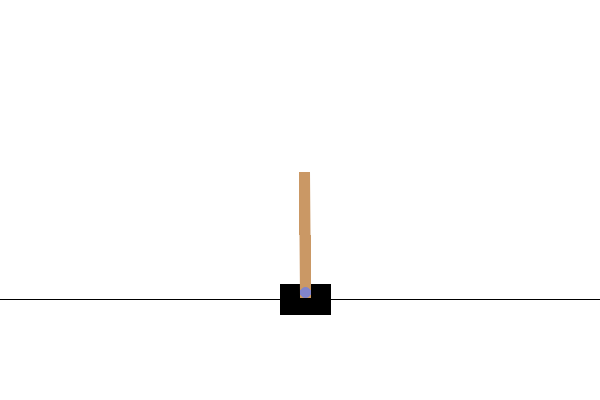

In [14]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)

## Next steps

This tutorial demonstrated how to implement the Actor-Critic method using Tensorflow.

As a next step, you could try training a model on a different environment in Gym. 

For additional information regarding Actor-Critic methods and the Cartpole-v0 problem, you may refer to the following resources:

- [The Actor-Critic method](https://hal.inria.fr/hal-00840470/document)
- [The Actor-Critic lecture (CAL)](https://www.youtube.com/watch?v=EKqxumCuAAY&list=PLkFD6_40KJIwhWJpGazJ9VSj9CFMkb79A&index=7&t=0s)
- [Cart Pole learning control problem \[Barto, et al. 1983\]](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf) 

For more reinforcement learning examples in TensorFlow, you can check the following resources:
- [Reinforcement learning code examples (keras.io)](https://keras.io/examples/rl/)
- [TF-Agents reinforcement learning library](https://www.tensorflow.org/agents)
